In [ ]:
!pip install transformers==4.28.0

Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predicti

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.269500,0.201834,0.920040,0.921623,0.903729,0.940240
2,0.145800,0.226071,0.924040,0.924406,0.919975,0.928880
3,0.080600,0.286842,0.924000,0.924435,0.919171,0.929760


Evaluation results: {'eval_loss': 0.22607052326202393, 'eval_accuracy': 0.92404, 'eval_f1': 0.9244058755622786, 'eval_precision': 0.9199746454322162, 'eval_recall': 0.92888, 'eval_runtime': 383.9698, 'eval_samples_per_second': 65.109, 'eval_steps_per_second': 2.037, 'epoch': 3.0}


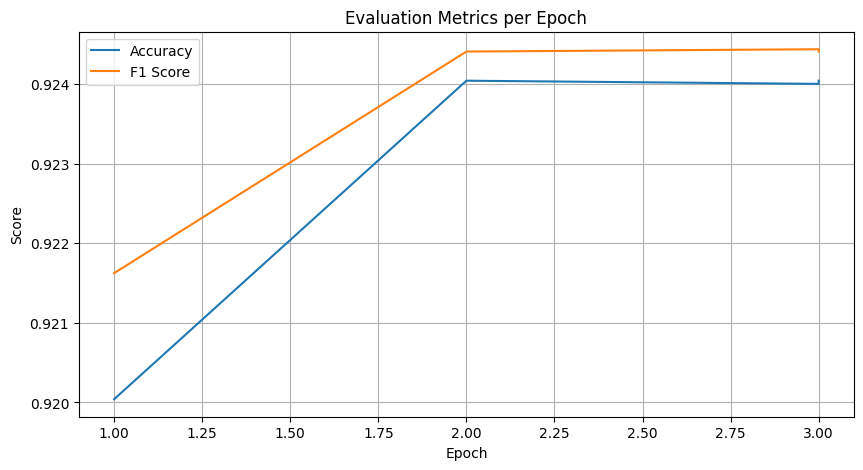

In [ ]:
# Install necessary packages
!pip install transformers datasets matplotlib

# Import necessary libraries
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from google.colab import drive
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mount Google Drive
drive.mount('/content/drive')

# Load the IMDb dataset
dataset = load_dataset('imdb')

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a function to tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)

# Tokenize the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Rename the label column to 'labels'
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Set the format for PyTorch
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to="none",  # prevent logging to wandb
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Load the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# Metric computation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
)

# Train the model
train_result = trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

# Save the model to Google Drive
model.save_pretrained('/content/drive/MyDrive/fine_tuned_bert')
tokenizer.save_pretrained('/content/drive/MyDrive/fine_tuned_bert')

# Plot training metrics
training_logs = trainer.state.log_history
epochs = [log['epoch'] for log in training_logs if 'eval_accuracy' in log]
accuracy = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]
f1_scores = [log['eval_f1'] for log in training_logs if 'eval_f1' in log]

plt.figure(figsize=(10,5))
plt.plot(epochs, accuracy, label='Accuracy')
plt.plot(epochs, f1_scores, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Evaluation Metrics per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Install required packages
!pip install transformers datasets matplotlib

# Import libraries
import torch
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load IMDb dataset
dataset = load_dataset('imdb')

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Load teacher model
teacher_model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/fine_tuned_bert").to(device)
# Load student model (a smaller version)
student_model = BertForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=2).to(device)

# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Custom trainer for distillation
from transformers import Trainer
class DistillationTrainer(Trainer):
    def __init__(self, teacher_model, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        self.alpha = alpha
        self.temperature = temperature
        self.teacher_model.eval()

    def compute_loss(self, model, inputs, return_outputs=False):
        student_outputs = model(**inputs)
        student_logits = student_outputs.logits

        with torch.no_grad():
            teacher_outputs = self.teacher_model(**inputs)
            teacher_logits = teacher_outputs.logits

        loss_fct = torch.nn.CrossEntropyLoss()
        hard_loss = loss_fct(student_logits, inputs['labels'])

        T = self.temperature
        soft_loss_fct = torch.nn.KLDivLoss(reduction="batchmean")
        soft_loss = soft_loss_fct(
            torch.nn.functional.log_softmax(student_logits / T, dim=-1),
            torch.nn.functional.softmax(teacher_logits / T, dim=-1)
        ) * (T * T)

        loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss
        return (loss, student_outputs) if return_outputs else loss

# Training arguments
training_args = TrainingArguments(
    output_dir="./kd_bert_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    metric_for_best_model="accuracy"
)

# Train and evaluate
trainer = DistillationTrainer(
    model=student_model,
    teacher_model=teacher_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
    alpha=0.5,
    temperature=2.0
)

print("\nStarting Knowledge Distillation Training...\n")
train_result = trainer.train()
print("\nTraining Complete. Evaluating...\n")
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

# Save the model
save_path = "/content/drive/MyDrive/distilled_bert_tiny"
student_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"\nStudent model saved to: {save_path}")

# Plot metrics
logs = trainer.state.log_history
epochs, accs, f1s = [], [], []
for log in logs:
    if 'eval_accuracy' in log:
        epochs.append(log['epoch'])
        accs.append(log['eval_accuracy'])
        f1s.append(log['eval_f1'])

plt.figure(figsize=(10, 5))
plt.plot(epochs, accs, label='Accuracy')
plt.plot(epochs, f1s, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Distilled Student Model Evaluation Metrics')
plt.legend()
plt.grid(True)
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia


Starting Knowledge Distillation Training...



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.944400,0.626592,0.808320,0.800017,0.836241,0.766800
2,0.620500,0.538668,0.832560,0.829324,0.845668,0.813600
3,0.559000,0.525400,0.836320,0.832597,0.851976,0.814080



Training Complete. Evaluating...



In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Path to your custom model in Google Drive
model_path = "/content/drive/MyDrive/fine_tuned_bert/"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Initialize sentiment pipeline with your custom model
sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Run sentiment prediction
print(sentiment_analysis("This was bad, but actors were great!"))
print(sentiment_analysis("This was the worst experience ever."))
print(sentiment_analysis("This was good, and actors were great as well!"))

Device set to use cpu


[{'label': 'LABEL_0', 'score': 0.9439799785614014}]
[{'label': 'LABEL_0', 'score': 0.9868287444114685}]
[{'label': 'LABEL_1', 'score': 0.9835475087165833}]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda

Starting Knowledge Distillation Training...



/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.959700,0.577295,0.817800,0.803520,0.871852,0.745120
2,0.489300,0.482439,0.851840,0.850609,0.857735,0.843600
3,0.396300,0.463128,0.856160,0.852162,0.876522,0.829120
4,0.345600,0.508395,0.855600,0.862266,0.824216,0.904000
5,0.303200,0.484452,0.857560,0.855438,0.868376,0.842880
6,0.269000,0.621694,0.842000,0.827405,0.911612,0.757440
7,0.251900,0.555374,0.855200,0.849342,0.885149,0.816320
8,0.235400,0.569147,0.857200,0.856048,0.863008,0.849200
9,0.221100,0.589168,0.856280,0.854399,0.865730,0.843360
10,0.208100,0.596371,0.856080,0.851714,0.878358,0.826640



Training Complete. Evaluating...



Evaluation Results: {'eval_loss': 0.4844515323638916, 'eval_accuracy': 0.85756, 'eval_f1': 0.855437827304835, 'eval_precision': 0.868375504821561, 'eval_recall': 0.84288, 'eval_runtime': 366.935, 'eval_samples_per_second': 68.132, 'eval_steps_per_second': 4.26, 'epoch': 10.0}

Student model saved to: /content/drive/MyDrive/distilled_bert_tiny


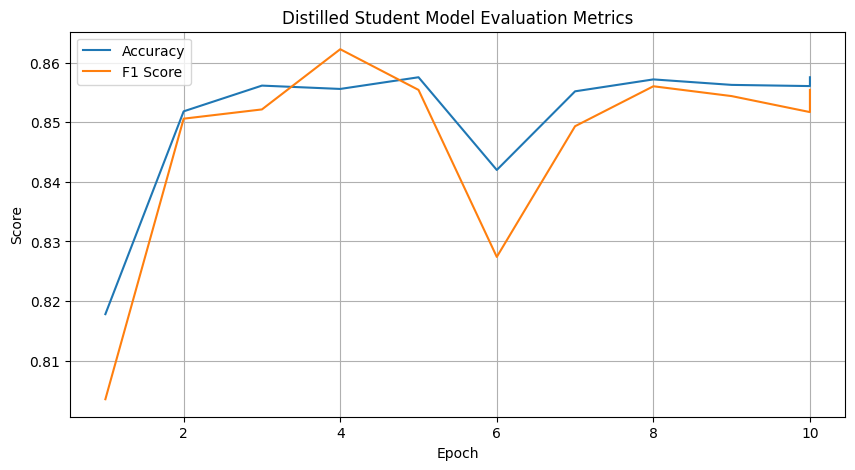

In [ ]:
# Install required packages
!pip install transformers datasets matplotlib

# Import libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification, BertModel, BertConfig, PreTrainedModel, Trainer, TrainingArguments
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load IMDb dataset
dataset = load_dataset('imdb')

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Load teacher model
teacher_model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/fine_tuned_bert").to(device)
# Load student model (a smaller version)
# === Custom Student Model ===

class CustomBertStudentModel(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

# Small config
student_config = BertConfig(
    hidden_size=312,
    num_hidden_layers=4,
    num_attention_heads=6,
    intermediate_size=1024,
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

# Create custom student model
student_model = CustomBertStudentModel(student_config).to(device)

# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Custom trainer for distillation
from transformers import Trainer
class DistillationTrainer(Trainer):
    def __init__(self, teacher_model, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        self.alpha = alpha
        self.temperature = temperature
        self.teacher_model.eval()

    def compute_loss(self, model, inputs, return_outputs=False):
        student_outputs = model(**inputs)
        student_logits = student_outputs.logits

        with torch.no_grad():
            teacher_outputs = self.teacher_model(**inputs)
            teacher_logits = teacher_outputs.logits

        loss_fct = torch.nn.CrossEntropyLoss()
        hard_loss = loss_fct(student_logits, inputs['labels'])

        T = self.temperature
        soft_loss_fct = torch.nn.KLDivLoss(reduction="batchmean")
        soft_loss = soft_loss_fct(
            torch.nn.functional.log_softmax(student_logits / T, dim=-1),
            torch.nn.functional.softmax(teacher_logits / T, dim=-1)
        ) * (T * T)

        loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss
        return (loss, student_outputs) if return_outputs else loss

# Training arguments
training_args = TrainingArguments(
    output_dir="./kd_bert_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    metric_for_best_model="accuracy"
)

# Train and evaluate
trainer = DistillationTrainer(
    model=student_model,
    teacher_model=teacher_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
    alpha=0.5,
    temperature=2.0
)

print("\nStarting Knowledge Distillation Training...\n")
train_result = trainer.train()
print("\nTraining Complete. Evaluating...\n")
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

# Save the model
save_path = "/content/drive/MyDrive/distilled_bert_tiny"
student_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"\nStudent model saved to: {save_path}")

# Plot metrics
logs = trainer.state.log_history
epochs, accs, f1s = [], [], []
for log in logs:
    if 'eval_accuracy' in log:
        epochs.append(log['epoch'])
        accs.append(log['eval_accuracy'])
        f1s.append(log['eval_f1'])

plt.figure(figsize=(10, 5))
plt.plot(epochs, accs, label='Accuracy')
plt.plot(epochs, f1s, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Distilled Student Model Evaluation Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Path to your custom model in Google Drive
model_path = "/content/drive/MyDrive/distilled_bert_tiny/"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Initialize sentiment pipeline with your custom model
sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Run sentiment prediction
# Run sentiment prediction
print(sentiment_analysis("This was bad, but actors were great!"))
print(sentiment_analysis("This was the worst experience ever."))
print(sentiment_analysis("This was good, and actors were great as well!"))


# Path to your custom model in Google Drive
model_path_2 = "/content/drive/MyDrive/fine_tuned_bert/"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path_2)
model2 = AutoModelForSequenceClassification.from_pretrained(model_path_2)

# Initialize sentiment pipeline with your custom model
sentiment_analysis = pipeline("sentiment-analysis", model=model2, tokenizer=tokenizer)

# Run sentiment prediction
# Run sentiment prediction
print(sentiment_analysis("This was bad, but actors were great!"))
print(sentiment_analysis("This was the worst experience ever."))
print(sentiment_analysis("This was good, and actors were great as well!"))

Device set to use cpu


[{'label': 'LABEL_0', 'score': 0.9954677820205688}]
[{'label': 'LABEL_0', 'score': 0.9973113536834717}]
[{'label': 'LABEL_1', 'score': 0.997312068939209}]


Device set to use cpu


[{'label': 'LABEL_0', 'score': 0.9439799785614014}]
[{'label': 'LABEL_0', 'score': 0.9868287444114685}]
[{'label': 'LABEL_1', 'score': 0.9835475087165833}]


In [ ]:
from transformers import (
    BertTokenizer, BertForSequenceClassification, BertModel, BertConfig,
    PreTrainedModel, Trainer, TrainingArguments
)
import torch
import torch.nn as nn
import torch.nn.functional as F
# Path to your custom model in Google Drive
# === Custom Student Model ===
class CustomBertStudentModel(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

# Small BERT config
student_config = BertConfig(
    hidden_size=312,
    num_hidden_layers=4,
    num_attention_heads=6,
    intermediate_size=1024,
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

student_model = CustomBertStudentModel(student_config)
print(f"Total parameters: {sum(p.numel() for p in student_model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in student_model.parameters() if p.requires_grad)}")

Total parameters: 13910874
Trainable parameters: 13910874


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda

Starting Knowledge Distillation Training...



/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.158900,0.083955,0.806120,0.794505,0.845134,0.749600
2,0.070300,0.068368,0.844080,0.844466,0.842382,0.846560
3,0.059600,0.064761,0.848760,0.850583,0.840453,0.860960
4,0.054200,0.063837,0.852160,0.853135,0.847545,0.858800
5,0.050300,0.063732,0.852560,0.853614,0.847555,0.859760



Training Complete. Evaluating...



Evaluation Results: {'eval_loss': 0.06373228132724762, 'eval_accuracy': 0.85256, 'eval_f1': 0.8536139793486894, 'eval_precision': 0.8475552050473186, 'eval_recall': 0.85976, 'eval_runtime': 391.38, 'eval_samples_per_second': 63.877, 'eval_steps_per_second': 3.994, 'epoch': 5.0}

Student model saved to: /content/drive/MyDrive/distilled_bert_tiny_CE_only


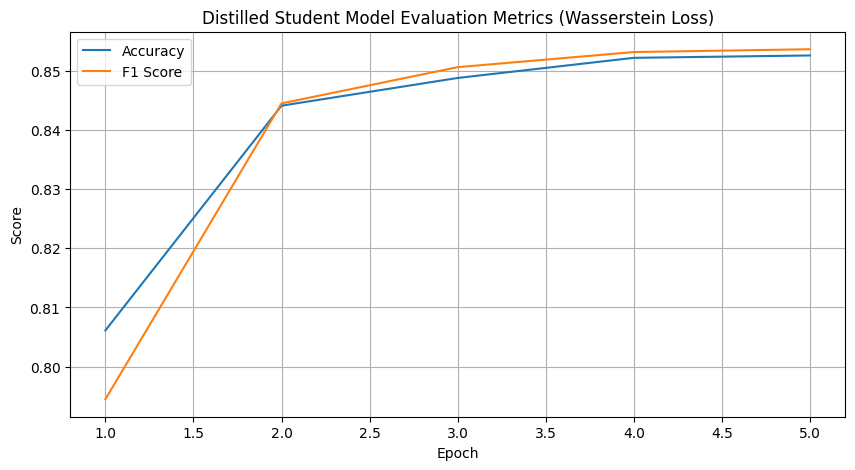

In [ ]:
# Install required packages
!pip install transformers datasets matplotlib -q

# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import (
    BertTokenizer, BertForSequenceClassification, BertModel, BertConfig,
    PreTrainedModel, Trainer, TrainingArguments
)
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load IMDb dataset
dataset = load_dataset('imdb')

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/fine_tuned_bert')

# Tokenization
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


# Load teacher model
teacher_model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/fine_tuned_bert").to(device)

# === Custom Student Model ===
class CustomBertStudentModel(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

# Small BERT config
student_config = BertConfig(
    hidden_size=312,
    num_hidden_layers=4,
    num_attention_heads=6,
    intermediate_size=1024,
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

student_model = CustomBertStudentModel(student_config).to(device)

# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Wasserstein distance loss
def wasserstein_distance(p_logits, q_logits):
    p = F.softmax(p_logits, dim=-1)
    q = F.softmax(q_logits, dim=-1)
    p_cdf = torch.cumsum(p, dim=-1)
    q_cdf = torch.cumsum(q, dim=-1)
    return torch.mean(torch.abs(p_cdf - q_cdf))

# Custom Trainer with Wasserstein distillation loss
class DistillationTrainer(Trainer):
    def __init__(self, teacher_model, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        self.alpha = alpha
        self.temperature = temperature
        self.teacher_model.eval()

    def compute_loss(self, model, inputs, return_outputs=False):
        student_outputs = model(**inputs)
        student_logits = student_outputs.logits

        with torch.no_grad():
            teacher_outputs = self.teacher_model(**inputs)
            teacher_logits = teacher_outputs.logits

        loss_fct = nn.CrossEntropyLoss()
        hard_loss = loss_fct(student_logits, inputs['labels'])

        T = self.temperature
        soft_loss = wasserstein_distance(student_logits / T, teacher_logits / T)

        loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss
        return (loss, student_outputs) if return_outputs else loss

# Training arguments
training_args = TrainingArguments(
    output_dir="./kd_bert_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    metric_for_best_model="accuracy"
)

# Initialize trainer
trainer = DistillationTrainer(
    model=student_model,
    teacher_model=teacher_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
    alpha=0,
    temperature=2.0
)

# Train
print("\nStarting Knowledge Distillation Training...\n")
train_result = trainer.train()
print("\nTraining Complete. Evaluating...\n")
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

# Save student model
save_path = "/content/drive/MyDrive/distilled_bert_tiny_CE_only"
student_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"\nStudent model saved to: {save_path}")

# Plotting
logs = trainer.state.log_history
epochs, accs, f1s = [], [], []
for log in logs:
    if 'eval_accuracy' in log:
        epochs.append(log['epoch'])
        accs.append(log['eval_accuracy'])
        f1s.append(log['eval_f1'])

plt.figure(figsize=(10, 5))
plt.plot(epochs, accs, label='Accuracy')
plt.plot(epochs, f1s, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Distilled Student Model Evaluation Metrics (Wasserstein Loss)')
plt.legend()
plt.grid(True)
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]


==== Training for Temperature: 2 ====


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1563,0.393400
3126,0.238600



==== Training for Temperature: 5 ====


Step,Training Loss
1563,0.355100
3126,0.223200



==== Training for Temperature: 10 ====


Step,Training Loss
1563,0.330900
3126,0.207300



==== Training for Temperature: 20 ====


Step,Training Loss
1563,0.316900
3126,0.197500



==== Training for Temperature: 30 ====


Step,Training Loss
1563,0.312100
3126,0.194000


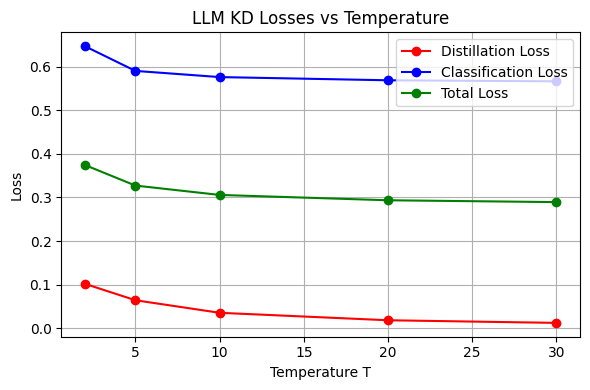

In [ ]:
# Install required packages (skip if already installed)
!pip install datasets matplotlib -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import (
    BertTokenizer, BertForSequenceClassification, BertModel, BertConfig,
    PreTrainedModel, Trainer, TrainingArguments
)
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from google.colab import drive

# Mount Google Drive (optional if models are stored there)
drive.mount('/content/drive')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load IMDb dataset
dataset = load_dataset('imdb')

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/fine_tuned_bert')

# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Load teacher model
teacher_model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/fine_tuned_bert').to(device)
teacher_model.eval()

# Define student model
class CustomBertStudentModel(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

# Custom distillation loss (Wasserstein)
def wasserstein_distance(p_logits, q_logits):
    p = F.softmax(p_logits, dim=-1)
    q = F.softmax(q_logits, dim=-1)
    p_cdf = torch.cumsum(p, dim=-1)
    q_cdf = torch.cumsum(q, dim=-1)
    return torch.mean(torch.abs(p_cdf - q_cdf))

# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Custom Trainer
class DistillationTrainer(Trainer):
    def __init__(self, teacher_model, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        self.alpha = alpha
        self.temperature = temperature
        self.teacher_model.eval()

    def compute_loss(self, model, inputs, return_outputs=False):
        student_outputs = model(**inputs)
        student_logits = student_outputs.logits

        with torch.no_grad():
            teacher_outputs = self.teacher_model(**inputs)
            teacher_logits = teacher_outputs.logits

        hard_loss = nn.CrossEntropyLoss()(student_logits, inputs['labels'])
        soft_loss = wasserstein_distance(student_logits / self.temperature, teacher_logits / self.temperature)
        loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss

        return (loss, student_outputs) if return_outputs else loss

# Student model config
student_config = BertConfig(
    hidden_size=312,
    num_hidden_layers=4,
    num_attention_heads=6,
    intermediate_size=1024,
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

# Training arguments
training_args = TrainingArguments(
    output_dir="./kd_bert_results",
    evaluation_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="no",
    logging_strategy="epoch",
    load_best_model_at_end=False,
    report_to="none"
)

# === Main Training Loop for Different Temperatures ===
temperatures = [2, 5, 10, 20, 30]
results = {
    "temperature": [],
    "classification_loss": [],
    "distillation_loss": [],
    "total_loss": []
}

for T in temperatures:
    print(f"\n==== Training for Temperature: {T} ====")

    # Reinitialize student model
    student_model = CustomBertStudentModel(student_config).to(device)

    # Create trainer
    trainer = DistillationTrainer(
        model=student_model,
        teacher_model=teacher_model,
        args=training_args,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['test'],
        compute_metrics=compute_metrics,
        alpha=0.5,
        temperature=T
    )

    # Train the student
    trainer.train()

    # Compute individual loss terms on eval batch
    eval_batch = next(iter(torch.utils.data.DataLoader(tokenized_datasets['test'], batch_size=32)))
    for k in eval_batch:
        eval_batch[k] = eval_batch[k].to(device)

    with torch.no_grad():
        s_logits = student_model(**eval_batch).logits
        t_logits = teacher_model(**eval_batch).logits

    ce = nn.CrossEntropyLoss()(s_logits, eval_batch['labels']).item()
    distill = wasserstein_distance(s_logits / T, t_logits / T).item()
    total = 0.5 * ce + 0.5 * distill

    results["temperature"].append(T)
    results["classification_loss"].append(ce)
    results["distillation_loss"].append(distill)
    results["total_loss"].append(total)

# === Plotting Losses ===
plt.figure(figsize=(6, 4))
plt.plot(results["temperature"], results["distillation_loss"], 'ro-', label="Distillation Loss")
plt.plot(results["temperature"], results["classification_loss"], 'bo-', label="Classification Loss")
plt.plot(results["temperature"], results["total_loss"], 'go-', label="Total Loss")
plt.xlabel("Temperature T")
plt.ylabel("Loss")
plt.title("LLM KD Losses vs Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# === Print Losses for Each Temperature ===
print("Temperature-wise Losses:")
print(f"{'Temp':<10}{'CE Loss':<15}{'Distill Loss':<20}{'Total Loss':<15}")
for i in range(len(results["temperature"])):
    temp = results["temperature"][i]
    ce = results["classification_loss"][i]
    distill = results["distillation_loss"][i]
    total = results["total_loss"][i]
    print(f"{temp:<10}{ce:<15.4f}{distill:<20.4f}{total:<15.4f}")


Temperature-wise Losses:
Temp      CE Loss        Distill Loss        Total Loss     
2         0.6466         0.1020              0.3743         
5         0.5899         0.0643              0.3271         
10        0.5758         0.0355              0.3057         
20        0.5684         0.0184              0.2934         
30        0.5660         0.0124              0.2892         


Mounted at /content/drive
Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]


==== Training for Temperature: 1 ====


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1563,0.411300
3126,0.236200


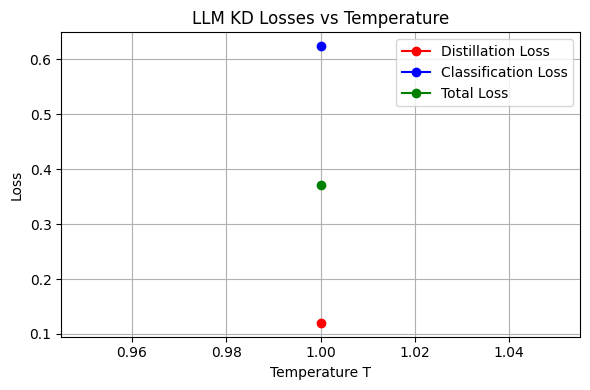

In [ ]:
# Install required packages (skip if already installed)
!pip install datasets matplotlib -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import (
    BertTokenizer, BertForSequenceClassification, BertModel, BertConfig,
    PreTrainedModel, Trainer, TrainingArguments
)
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from google.colab import drive

# Mount Google Drive (optional if models are stored there)
drive.mount('/content/drive')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load IMDb dataset
dataset = load_dataset('imdb')

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/fine_tuned_bert')

# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Load teacher model
teacher_model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/fine_tuned_bert').to(device)
teacher_model.eval()

# Define student model
class CustomBertStudentModel(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

# Custom distillation loss (Wasserstein)
def wasserstein_distance(p_logits, q_logits):
    p = F.softmax(p_logits, dim=-1)
    q = F.softmax(q_logits, dim=-1)
    p_cdf = torch.cumsum(p, dim=-1)
    q_cdf = torch.cumsum(q, dim=-1)
    return torch.mean(torch.abs(p_cdf - q_cdf))

# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Custom Trainer
class DistillationTrainer(Trainer):
    def __init__(self, teacher_model, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        self.alpha = alpha
        self.temperature = temperature
        self.teacher_model.eval()

    def compute_loss(self, model, inputs, return_outputs=False):
        student_outputs = model(**inputs)
        student_logits = student_outputs.logits

        with torch.no_grad():
            teacher_outputs = self.teacher_model(**inputs)
            teacher_logits = teacher_outputs.logits

        hard_loss = nn.CrossEntropyLoss()(student_logits, inputs['labels'])
        soft_loss = wasserstein_distance(student_logits / self.temperature, teacher_logits / self.temperature)
        loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss

        return (loss, student_outputs) if return_outputs else loss

# Student model config
student_config = BertConfig(
    hidden_size=312,
    num_hidden_layers=4,
    num_attention_heads=6,
    intermediate_size=1024,
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

# Training arguments
training_args = TrainingArguments(
    output_dir="./kd_bert_results",
    evaluation_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="no",
    logging_strategy="epoch",
    load_best_model_at_end=False,
    report_to="none"
)

# === Main Training Loop for Different Temperatures ===
temperatures = [1]
results = {
    "temperature": [],
    "classification_loss": [],
    "distillation_loss": [],
    "total_loss": []
}

for T in temperatures:
    print(f"\n==== Training for Temperature: {T} ====")

    # Reinitialize student model
    student_model = CustomBertStudentModel(student_config).to(device)

    # Create trainer
    trainer = DistillationTrainer(
        model=student_model,
        teacher_model=teacher_model,
        args=training_args,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['test'],
        compute_metrics=compute_metrics,
        alpha=0.5,
        temperature=T
    )

    # Train the student
    trainer.train()

    # Compute individual loss terms on eval batch
    eval_batch = next(iter(torch.utils.data.DataLoader(tokenized_datasets['test'], batch_size=32)))
    for k in eval_batch:
        eval_batch[k] = eval_batch[k].to(device)

    with torch.no_grad():
        s_logits = student_model(**eval_batch).logits
        t_logits = teacher_model(**eval_batch).logits

    ce = nn.CrossEntropyLoss()(s_logits, eval_batch['labels']).item()
    distill = wasserstein_distance(s_logits / T, t_logits / T).item()
    total = 0.5 * ce + 0.5 * distill

    results["temperature"].append(T)
    results["classification_loss"].append(ce)
    results["distillation_loss"].append(distill)
    results["total_loss"].append(total)

# === Plotting Losses ===
plt.figure(figsize=(6, 4))
plt.plot(results["temperature"], results["distillation_loss"], 'ro-', label="Distillation Loss")
plt.plot(results["temperature"], results["classification_loss"], 'bo-', label="Classification Loss")
plt.plot(results["temperature"], results["total_loss"], 'go-', label="Total Loss")
plt.xlabel("Temperature T")
plt.ylabel("Loss")
plt.title("LLM KD Losses vs Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# === Print Losses for Each Temperature ===
print("Temperature-wise Losses:")
print(f"{'Temp':<10}{'CE Loss':<15}{'Distill Loss':<20}{'Total Loss':<15}")
for i in range(len(results["temperature"])):
    temp = results["temperature"][i]
    ce = results["classification_loss"][i]
    distill = results["distillation_loss"][i]
    total = results["total_loss"][i]
    print(f"{temp:<10}{ce:<15.4f}{distill:<20.4f}{total:<15.4f}")

Temperature-wise Losses:
Temp      CE Loss        Distill Loss        Total Loss     
1         0.6239         0.1201              0.3720         


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using: cuda


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sh7vashrestha (sh7vashrestha-tribhuvan-university-institute-of-engineering) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.378300,0.372801,0.526000,0.059524,0.937500,0.030738
2,0.376800,0.363861,0.529000,0.670860,0.509014,0.983607
3,0.348400,0.292989,0.737000,0.700114,0.789203,0.629098
4,0.214700,0.288201,0.760000,0.735099,0.796651,0.682377
5,0.182900,0.302568,0.775000,0.773414,0.760396,0.786885
6,0.166000,0.383781,0.774000,0.793419,0.716172,0.889344
7,0.164800,0.382066,0.783000,0.790338,0.747715,0.838115
8,0.136400,0.394057,0.790000,0.789579,0.772549,0.807377
9,0.132800,0.400972,0.789000,0.787940,0.773176,0.803279
10,0.115900,0.409270,0.790000,0.789579,0.772549,0.807377


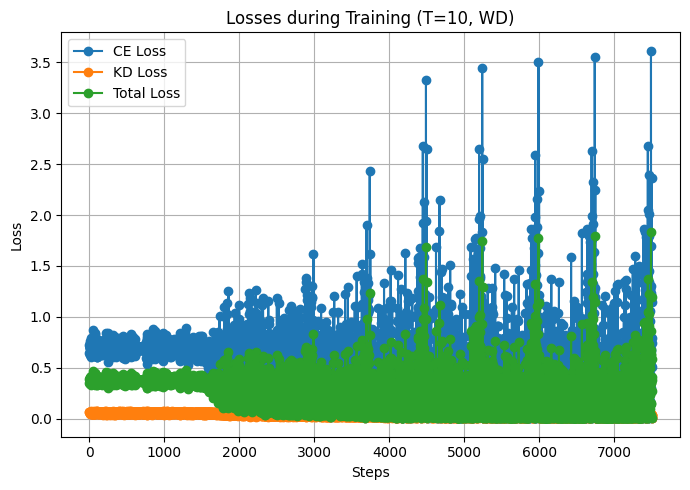

In [ ]:
# === Install required libraries ===
!pip install transformers datasets -q

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel, BertConfig, PreTrainedModel
from transformers import Trainer, TrainingArguments
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from google.colab import drive
import matplotlib.pyplot as plt
import os

# === Mount Google Drive ===
drive.mount('/content/drive')

# === Set device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# === Load IMDb Dataset ===
dataset = load_dataset("imdb")
dataset = dataset.shuffle(seed=42)
small_train = dataset["train"].select(range(5000))
small_test = dataset["test"].select(range(1000))

# === Load tokenizer ===
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/fine_tuned_bert')

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_ds = small_train.map(tokenize_function, batched=True)
test_ds = small_test.map(tokenize_function, batched=True)
train_ds = train_ds.rename_column("label", "labels")
test_ds = test_ds.rename_column("label", "labels")
train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# === Load teacher model ===
from transformers import BertForSequenceClassification
teacher_model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/fine_tuned_bert').to(device)
teacher_model.eval()

# === Student model definition ===
class CustomBertStudentModel(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

# === Wasserstein Distance ===
def wasserstein_distance(p_logits, q_logits):
    p = F.softmax(p_logits, dim=-1)
    q = F.softmax(q_logits, dim=-1)
    p_cdf = torch.cumsum(p, dim=-1)
    q_cdf = torch.cumsum(q, dim=-1)
    return torch.mean(torch.abs(p_cdf - q_cdf))

# === Compute metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# === Custom Trainer ===
class DistillationTrainer(Trainer):
    def __init__(self, teacher_model, *args, alpha=0.5, temperature=10.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        self.alpha = alpha
        self.temperature = temperature
        self.teacher_model.eval()
        self.logs = []

    def compute_loss(self, model, inputs, return_outputs=False):
        student_outputs = model(**inputs)
        student_logits = student_outputs.logits

        with torch.no_grad():
            teacher_outputs = self.teacher_model(**inputs)
            teacher_logits = teacher_outputs.logits

        hard_loss = nn.CrossEntropyLoss()(student_logits, inputs["labels"])
        soft_loss = wasserstein_distance(student_logits / self.temperature, teacher_logits / self.temperature)
        total_loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss

        self.logs.append({
            "ce_loss": hard_loss.item(),
            "kd_loss": soft_loss.item(),
            "total_loss": total_loss.item()
        })

        return (total_loss, student_outputs) if return_outputs else total_loss

# === Model Config and Training Args ===
student_config = BertConfig(
    hidden_size=312,
    num_hidden_layers=4,
    num_attention_heads=6,
    intermediate_size=1024,
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

student_model = CustomBertStudentModel(student_config).to(device)

output_dir = "/content/drive/MyDrive/bert_tiny_temp10_WD"
os.makedirs(output_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1,
    save_strategy="epoch"
)

trainer = DistillationTrainer(
    model=student_model,
    teacher_model=teacher_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    alpha=0.5,
    temperature=10.0
)

trainer.train()

# === Save best model ===
trainer.save_model(output_dir)

# === Plot Losses ===
ce_losses = [log["ce_loss"] for log in trainer.logs]
kd_losses = [log["kd_loss"] for log in trainer.logs]
total_losses = [log["total_loss"] for log in trainer.logs]

plt.figure(figsize=(7, 5))
plt.plot(ce_losses, label="CE Loss", marker='o')
plt.plot(kd_losses, label="KD Loss", marker='o')
plt.plot(total_losses, label="Total Loss", marker='o')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Losses during Training (T=10, WD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.364600,0.359216,0.523000,0.047904,0.923077,0.024590
2,0.364300,0.355915,0.500000,0.660787,0.493915,0.997951
3,0.353800,0.300600,0.698000,0.660674,0.731343,0.602459
4,0.248200,0.293752,0.722000,0.715746,0.714286,0.717213
5,0.227700,0.292303,0.724000,0.722334,0.709486,0.735656


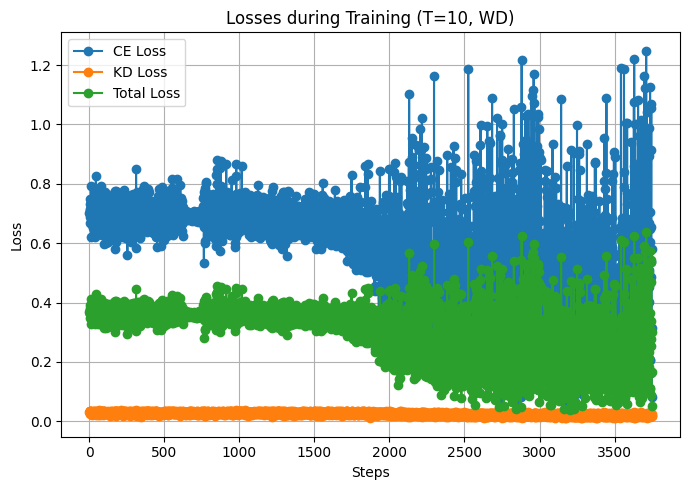

In [ ]:


# === Student model definition ===
class CustomBertStudentModel(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

# === Wasserstein Distance ===
def wasserstein_distance(p_logits, q_logits):
    p = F.softmax(p_logits, dim=-1)
    q = F.softmax(q_logits, dim=-1)
    p_cdf = torch.cumsum(p, dim=-1)
    q_cdf = torch.cumsum(q, dim=-1)
    return torch.mean(torch.abs(p_cdf - q_cdf))

# === Compute metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# === Custom Trainer ===
class DistillationTrainer(Trainer):
    def __init__(self, teacher_model, *args, alpha=0.5, temperature=10.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        self.alpha = alpha
        self.temperature = temperature
        self.teacher_model.eval()
        self.logs = []

    def compute_loss(self, model, inputs, return_outputs=False):
        student_outputs = model(**inputs)
        student_logits = student_outputs.logits

        with torch.no_grad():
            teacher_outputs = self.teacher_model(**inputs)
            teacher_logits = teacher_outputs.logits

        hard_loss = nn.CrossEntropyLoss()(student_logits, inputs["labels"])
        soft_loss = wasserstein_distance(student_logits / self.temperature, teacher_logits / self.temperature)
        total_loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss

        self.logs.append({
            "ce_loss": hard_loss.item(),
            "kd_loss": soft_loss.item(),
            "total_loss": total_loss.item()
        })

        return (total_loss, student_outputs) if return_outputs else total_loss

# === Model Config and Training Args ===
student_config = BertConfig(
    hidden_size=312,
    num_hidden_layers=4,
    num_attention_heads=6,
    intermediate_size=1024,
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

student_model = CustomBertStudentModel(student_config).to(device)

output_dir = "/content/drive/MyDrive/bert_tiny_temp20_WD"
os.makedirs(output_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1,
    save_strategy="epoch"
)

trainer = DistillationTrainer(
    model=student_model,
    teacher_model=teacher_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    alpha=0.5,
    temperature=20.0
)

trainer.train()

# === Save best model ===
trainer.save_model(output_dir)

# === Plot Losses ===
ce_losses = [log["ce_loss"] for log in trainer.logs]
kd_losses = [log["kd_loss"] for log in trainer.logs]
total_losses = [log["total_loss"] for log in trainer.logs]

plt.figure(figsize=(7, 5))
plt.plot(ce_losses, label="CE Loss", marker='o')
plt.plot(kd_losses, label="KD Loss", marker='o')
plt.plot(total_losses, label="Total Loss", marker='o')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Losses during Training (T=10, WD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.359600,0.354713,0.512000,0.000000,0.000000,0.000000
2,0.357800,0.351024,0.503000,0.661213,0.495403,0.993852
3,0.349000,0.297715,0.684000,0.640091,0.720513,0.575820
4,0.244500,0.290113,0.733000,0.735905,0.711281,0.762295
5,0.222300,0.286770,0.735000,0.733668,0.719921,0.747951


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


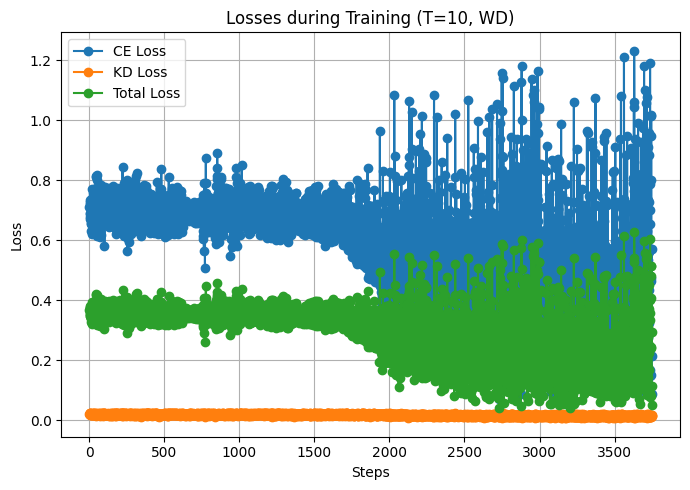

In [ ]:


# === Student model definition ===
class CustomBertStudentModel(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

# === Wasserstein Distance ===
def wasserstein_distance(p_logits, q_logits):
    p = F.softmax(p_logits, dim=-1)
    q = F.softmax(q_logits, dim=-1)
    p_cdf = torch.cumsum(p, dim=-1)
    q_cdf = torch.cumsum(q, dim=-1)
    return torch.mean(torch.abs(p_cdf - q_cdf))

# === Compute metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# === Custom Trainer ===
class DistillationTrainer(Trainer):
    def __init__(self, teacher_model, *args, alpha=0.5, temperature=10.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        self.alpha = alpha
        self.temperature = temperature
        self.teacher_model.eval()
        self.logs = []

    def compute_loss(self, model, inputs, return_outputs=False):
        student_outputs = model(**inputs)
        student_logits = student_outputs.logits

        with torch.no_grad():
            teacher_outputs = self.teacher_model(**inputs)
            teacher_logits = teacher_outputs.logits

        hard_loss = nn.CrossEntropyLoss()(student_logits, inputs["labels"])
        soft_loss = wasserstein_distance(student_logits / self.temperature, teacher_logits / self.temperature)
        total_loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss

        self.logs.append({
            "ce_loss": hard_loss.item(),
            "kd_loss": soft_loss.item(),
            "total_loss": total_loss.item()
        })

        return (total_loss, student_outputs) if return_outputs else total_loss

# === Model Config and Training Args ===
student_config = BertConfig(
    hidden_size=312,
    num_hidden_layers=4,
    num_attention_heads=6,
    intermediate_size=1024,
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

student_model = CustomBertStudentModel(student_config).to(device)

output_dir = "/content/drive/MyDrive/bert_tiny_temp20_WD"
os.makedirs(output_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1,
    save_strategy="epoch"
)

trainer = DistillationTrainer(
    model=student_model,
    teacher_model=teacher_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    alpha=0.5,
    temperature=30.0
)

trainer.train()

# === Save best model ===
trainer.save_model(output_dir)

# === Plot Losses ===
ce_losses = [log["ce_loss"] for log in trainer.logs]
kd_losses = [log["kd_loss"] for log in trainer.logs]
total_losses = [log["total_loss"] for log in trainer.logs]

plt.figure(figsize=(7, 5))
plt.plot(ce_losses, label="CE Loss", marker='o')
plt.plot(kd_losses, label="KD Loss", marker='o')
plt.plot(total_losses, label="Total Loss", marker='o')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Losses during Training (T=10, WD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]


Starting Knowledge Distillation Training...



/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.559800,0.774038,0.833960,0.834179,0.833081,0.835280
2,0.728200,0.665777,0.856080,0.854544,0.863763,0.845520
3,0.583800,0.668745,0.857040,0.851381,0.886474,0.818960
4,0.498200,0.700282,0.857280,0.865002,0.820603,0.914480
5,0.439900,0.669761,0.862960,0.862343,0.866242,0.858480
6,0.393300,0.721308,0.858080,0.853316,0.882957,0.825600
7,0.364000,0.714471,0.861400,0.860164,0.867905,0.852560
8,0.338000,0.742157,0.860800,0.862364,0.852785,0.872160
9,0.321000,0.754302,0.861080,0.860135,0.866029,0.854320
10,0.302900,0.746444,0.860840,0.859689,0.866856,0.852640



Training Complete. Evaluating...



Evaluation Results: {'eval_loss': 0.6697610020637512, 'eval_accuracy': 0.86296, 'eval_f1': 0.8623432979749277, 'eval_precision': 0.8662415240555377, 'eval_recall': 0.85848, 'eval_runtime': 410.658, 'eval_samples_per_second': 60.878, 'eval_steps_per_second': 3.806, 'epoch': 10.0}

Student model saved to: /content/drive/MyDrive/distilled_bert_tiny_KLD_temp10
Saved loss table to: /content/drive/MyDrive/distilled_bert_tiny_KLD_temp10/loss_per_epoch.csv

Loss Table:
  epoch  classification_loss  distillation_loss  total_loss
     1             0.536589           0.425009    0.480799
     2             0.485755           0.289316    0.387536
     3             0.514445           0.214197    0.364321
     4             0.751195           0.653371    0.702283
     5             0.661357           0.399750    0.530554
     6             0.650562           0.396823    0.523693
     7             0.705412           0.493813    0.599612
     8             0.740871           0.561839    0.651355
  

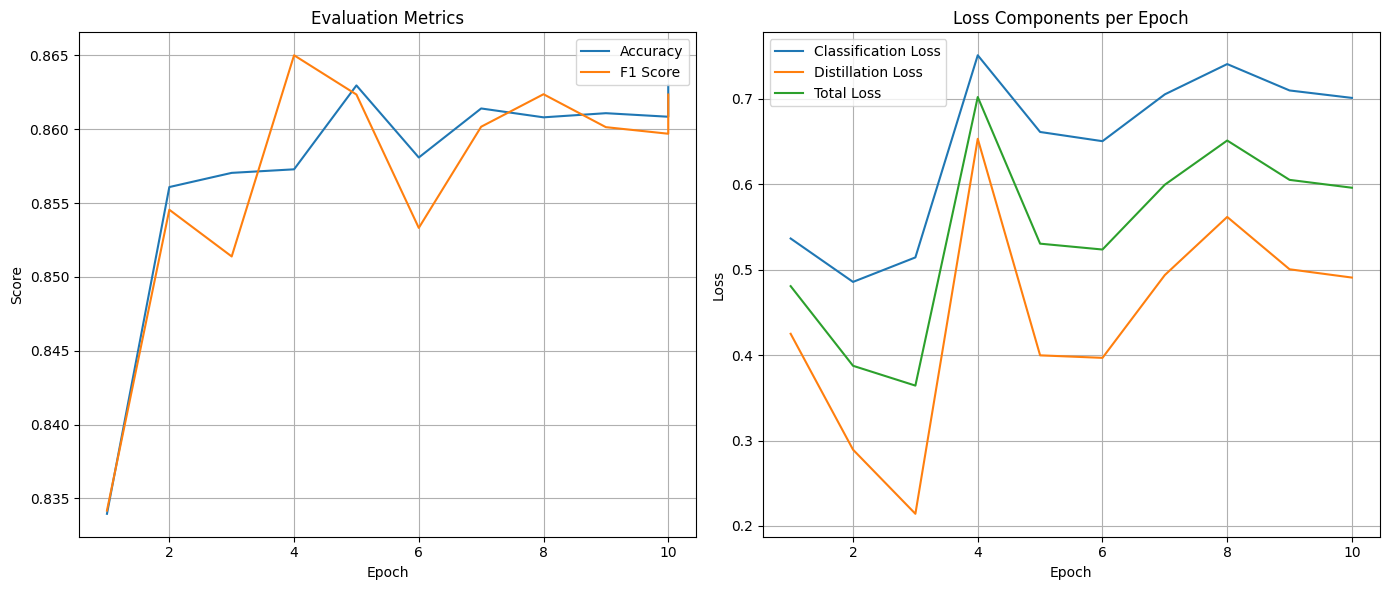

Saved plot to: /content/drive/MyDrive/distilled_bert_tiny_KLD_temp10/metrics_and_losses.png


In [ ]:
# Install packages
!pip install transformers datasets matplotlib

# Import libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import os
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    BertModel, BertConfig, PreTrainedModel,
    Trainer, TrainingArguments
)
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset and tokenizer
dataset = load_dataset('imdb')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Load teacher model
teacher_model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/fine_tuned_bert").to(device)

# Define custom student model
class CustomBertStudentModel(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

# Student model config
student_config = BertConfig(
    hidden_size=312,
    num_hidden_layers=4,
    num_attention_heads=6,
    intermediate_size=1024,
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

student_model = CustomBertStudentModel(student_config).to(device)

# Metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Custom DistillationTrainer
class DistillationTrainer(Trainer):
    def __init__(self, teacher_model, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        self.alpha = alpha
        self.temperature = temperature
        self.teacher_model.eval()
        self.loss_tracker = {'epoch': [], 'classification_loss': [], 'distillation_loss': [], 'total_loss': []}

    def compute_loss(self, model, inputs, return_outputs=False):
        student_outputs = model(**inputs)
        student_logits = student_outputs.logits

        with torch.no_grad():
            teacher_outputs = self.teacher_model(**inputs)
            teacher_logits = teacher_outputs.logits

        labels = inputs['labels']
        hard_loss = nn.CrossEntropyLoss()(student_logits, labels)

        T = self.temperature
        soft_loss = nn.KLDivLoss(reduction="batchmean")(
            torch.nn.functional.log_softmax(student_logits / T, dim=-1),
            torch.nn.functional.softmax(teacher_logits / T, dim=-1)
        ) * (T * T)

        total_loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss

        # Logging per epoch
        if self.state.epoch is not None:
            current_epoch = int(self.state.epoch)
            if current_epoch > len(self.loss_tracker['epoch']):
                self.loss_tracker['epoch'].append(current_epoch)
                self.loss_tracker['classification_loss'].append(hard_loss.item())
                self.loss_tracker['distillation_loss'].append(soft_loss.item())
                self.loss_tracker['total_loss'].append(total_loss.item())

        return (total_loss, student_outputs) if return_outputs else total_loss

# Training arguments
training_args = TrainingArguments(
    output_dir="./kd_bert_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    metric_for_best_model="accuracy"
)

# Trainer setup
trainer = DistillationTrainer(
    model=student_model,
    teacher_model=teacher_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
    alpha=0.5,
    temperature=10.0
)

# Train
print("\nStarting Knowledge Distillation Training...\n")
train_result = trainer.train()
print("\nTraining Complete. Evaluating...\n")
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

# Save student model and tokenizer
save_path = "/content/drive/MyDrive/distilled_bert_tiny_KLD_temp10"
student_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"\nStudent model saved to: {save_path}")

# Save loss CSV
loss_df = pd.DataFrame(trainer.loss_tracker)
csv_path = os.path.join(save_path, "loss_per_epoch.csv")
loss_df.to_csv(csv_path, index=False)
print(f"Saved loss table to: {csv_path}")
print("\nLoss Table:\n", loss_df.to_string(index=False))

# PlottingW
logs = trainer.state.log_history
epochs, accs, f1s = [], [], []
for log in logs:
    if 'eval_accuracy' in log:
        epochs.append(log['epoch'])
        accs.append(log['eval_accuracy'])
        f1s.append(log['eval_f1'])

plt.figure(figsize=(14, 6))

# Evaluation Metrics
plt.subplot(1, 2, 1)
plt.plot(epochs, accs, label='Accuracy')
plt.plot(epochs, f1s, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.legend()
plt.grid(True)

# Losses
plt.subplot(1, 2, 2)
plt.plot(loss_df['epoch'], loss_df['classification_loss'], label='Classification Loss')
plt.plot(loss_df['epoch'], loss_df['distillation_loss'], label='Distillation Loss')
plt.plot(loss_df['epoch'], loss_df['total_loss'], label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Components per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plot_path = os.path.join(save_path, "metrics_and_losses.png")
plt.savefig(plot_path)
plt.show()
print(f"Saved plot to: {plot_path}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]


Starting Knowledge Distillation Training with Wasserstein Loss...



/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.315000,0.220103,0.818000,0.805156,0.866292,0.752080
2,0.187900,0.205813,0.850000,0.850954,0.845577,0.856400
3,0.156700,0.209953,0.841160,0.828192,0.901819,0.765680
4,0.136400,0.203896,0.859080,0.861174,0.848567,0.874160
5,0.123900,0.224309,0.853360,0.847707,0.881697,0.816240
6,0.110600,0.256453,0.851640,0.845914,0.879872,0.814480
7,0.106000,0.266324,0.848040,0.840385,0.884966,0.800080
8,0.097000,0.285810,0.852640,0.849411,0.868439,0.831200
9,0.092100,0.306937,0.847960,0.841208,0.880301,0.805440
10,0.084800,0.305707,0.848680,0.842290,0.879429,0.808160



Training Complete. Evaluating...



Evaluation Results: {'eval_loss': 0.20389637351036072, 'eval_accuracy': 0.85908, 'eval_f1': 0.8611735035662214, 'eval_precision': 0.8485672128601383, 'eval_recall': 0.87416, 'eval_runtime': 372.6125, 'eval_samples_per_second': 67.094, 'eval_steps_per_second': 4.195, 'epoch': 10.0}

Student model saved to: /content/drive/MyDrive/distilled_bert_tiny_WD_temp10
Saved loss table to: /content/drive/MyDrive/distilled_bert_tiny_WD_temp10/loss_per_epoch.csv

Loss Table:
  epoch  classification_loss  distillation_loss  total_loss
     1             0.202084           0.026398    0.114241
     2             0.297012           0.018482    0.157747
     3             0.165225           0.014879    0.090052
     4             0.332333           0.018405    0.175369
     5             0.149337           0.013298    0.081317
     6             0.156205           0.012546    0.084375
     7             0.105501           0.013259    0.059380
     8             0.178250           0.014495    0.096372
  

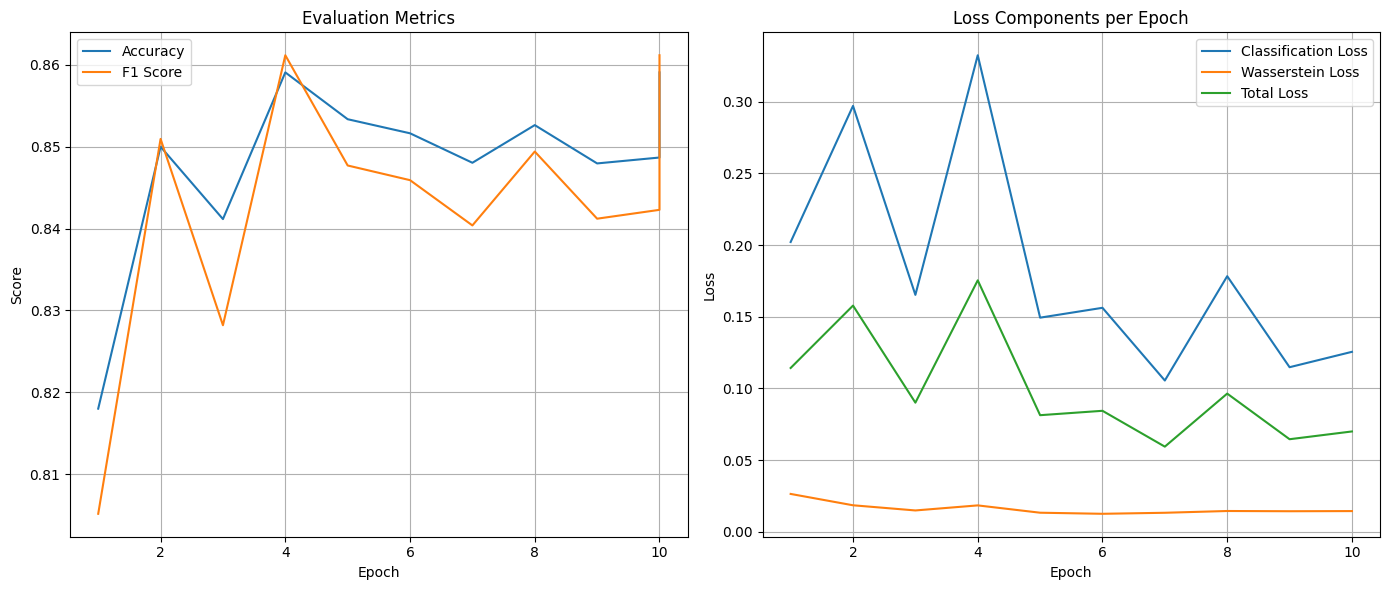

Saved plot to: /content/drive/MyDrive/distilled_bert_tiny_WD_temp10/metrics_and_losses.png


In [ ]:
# Install packages
!pip install transformers datasets matplotlib

# Import libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import os
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    BertModel, BertConfig, PreTrainedModel,
    Trainer, TrainingArguments
)
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset and tokenizer
dataset = load_dataset('imdb')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Load teacher model
teacher_model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/fine_tuned_bert").to(device)

# Define custom student model
class CustomBertStudentModel(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

# Student model config
student_config = BertConfig(
    hidden_size=312,
    num_hidden_layers=4,
    num_attention_heads=6,
    intermediate_size=1024,
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

student_model = CustomBertStudentModel(student_config).to(device)

# Metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Wasserstein distance function
def wasserstein_distance(p_logits, q_logits):
    p = torch.softmax(p_logits, dim=-1)
    q = torch.softmax(q_logits, dim=-1)
    p_cdf = torch.cumsum(p, dim=-1)
    q_cdf = torch.cumsum(q, dim=-1)
    return torch.mean(torch.abs(p_cdf - q_cdf))

# Custom Trainer with Wasserstein KD loss
class DistillationTrainer(Trainer):
    def __init__(self, teacher_model, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        self.alpha = alpha
        self.temperature = temperature
        self.teacher_model.eval()
        self.loss_tracker = {'epoch': [], 'classification_loss': [], 'distillation_loss': [], 'total_loss': []}

    def compute_loss(self, model, inputs, return_outputs=False):
        student_outputs = model(**inputs)
        student_logits = student_outputs.logits

        with torch.no_grad():
            teacher_outputs = self.teacher_model(**inputs)
            teacher_logits = teacher_outputs.logits

        labels = inputs['labels']
        hard_loss = nn.CrossEntropyLoss()(student_logits, labels)

        T = self.temperature
        soft_loss = wasserstein_distance(student_logits / T, teacher_logits / T)

        total_loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss

        # Logging
        if self.state.epoch is not None:
            current_epoch = int(self.state.epoch)
            if current_epoch > len(self.loss_tracker['epoch']):
                self.loss_tracker['epoch'].append(current_epoch)
                self.loss_tracker['classification_loss'].append(hard_loss.item())
                self.loss_tracker['distillation_loss'].append(soft_loss.item())
                self.loss_tracker['total_loss'].append(total_loss.item())

        return (total_loss, student_outputs) if return_outputs else total_loss

# Training arguments
training_args = TrainingArguments(
    output_dir="./kd_bert_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    metric_for_best_model="accuracy"
)

# Initialize trainer
trainer = DistillationTrainer(
    model=student_model,
    teacher_model=teacher_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
    alpha=0.5,
    temperature=10.0
)

# Train
print("\nStarting Knowledge Distillation Training with Wasserstein Loss...\n")
train_result = trainer.train()
print("\nTraining Complete. Evaluating...\n")
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

# Save model + tokenizer
save_path = "/content/drive/MyDrive/distilled_bert_tiny_WD_temp10"
student_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"\nStudent model saved to: {save_path}")

# Save loss CSV
loss_df = pd.DataFrame(trainer.loss_tracker)
csv_path = os.path.join(save_path, "loss_per_epoch.csv")
loss_df.to_csv(csv_path, index=False)
print(f"Saved loss table to: {csv_path}")
print("\nLoss Table:\n", loss_df.to_string(index=False))

# Plotting
logs = trainer.state.log_history
epochs, accs, f1s = [], [], []
for log in logs:
    if 'eval_accuracy' in log:
        epochs.append(log['epoch'])
        accs.append(log['eval_accuracy'])
        f1s.append(log['eval_f1'])

plt.figure(figsize=(14, 6))

# Eval Metrics
plt.subplot(1, 2, 1)
plt.plot(epochs, accs, label='Accuracy')
plt.plot(epochs, f1s, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.legend()
plt.grid(True)

# Losses
plt.subplot(1, 2, 2)
plt.plot(loss_df['epoch'], loss_df['classification_loss'], label='Classification Loss')
plt.plot(loss_df['epoch'], loss_df['distillation_loss'], label='Wasserstein Loss')
plt.plot(loss_df['epoch'], loss_df['total_loss'], label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Components per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plot_path = os.path.join(save_path, "metrics_and_losses.png")
plt.savefig(plot_path)
plt.show()
print(f"Saved plot to: {plot_path}")


In [ ]:
!rm -rf ~/.cache/huggingface/datasets
!rm -rf ~/.cache/huggingface/hub
!pip install --upgrade datasets fsspec huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]


Starting Knowledge Distillation Training...



/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.613700,0.814624,0.829080,0.828524,0.831226,0.825840
2,0.759000,0.711400,0.848720,0.844516,0.868657,0.821680
3,0.607200,0.669944,0.855520,0.853218,0.867030,0.839840
4,0.535700,0.693936,0.857840,0.855364,0.870527,0.840720
5,0.495600,0.706157,0.858720,0.856001,0.872797,0.839840



Training Complete. Evaluating...



Evaluation Results: {'eval_loss': 0.7061570882797241, 'eval_accuracy': 0.85872, 'eval_f1': 0.8560013046314416, 'eval_precision': 0.872796807449285, 'eval_recall': 0.83984, 'eval_runtime': 391.7708, 'eval_samples_per_second': 63.813, 'eval_steps_per_second': 3.99, 'epoch': 5.0}

Student model saved to: /content/drive/MyDrive/distilled_bert_tiny_KLD_temp20
Saved loss table to: /content/drive/MyDrive/distilled_bert_tiny_KLD_temp20/loss_per_epoch.csv

Loss Table:
  epoch  classification_loss  distillation_loss  total_loss
     1             0.470085           0.635151    0.552618
     2             0.486245           0.418221    0.452233
     3             0.579430           0.457248    0.518339
     4             0.619676           0.472302    0.545989
     5             0.637988           0.477605    0.557796


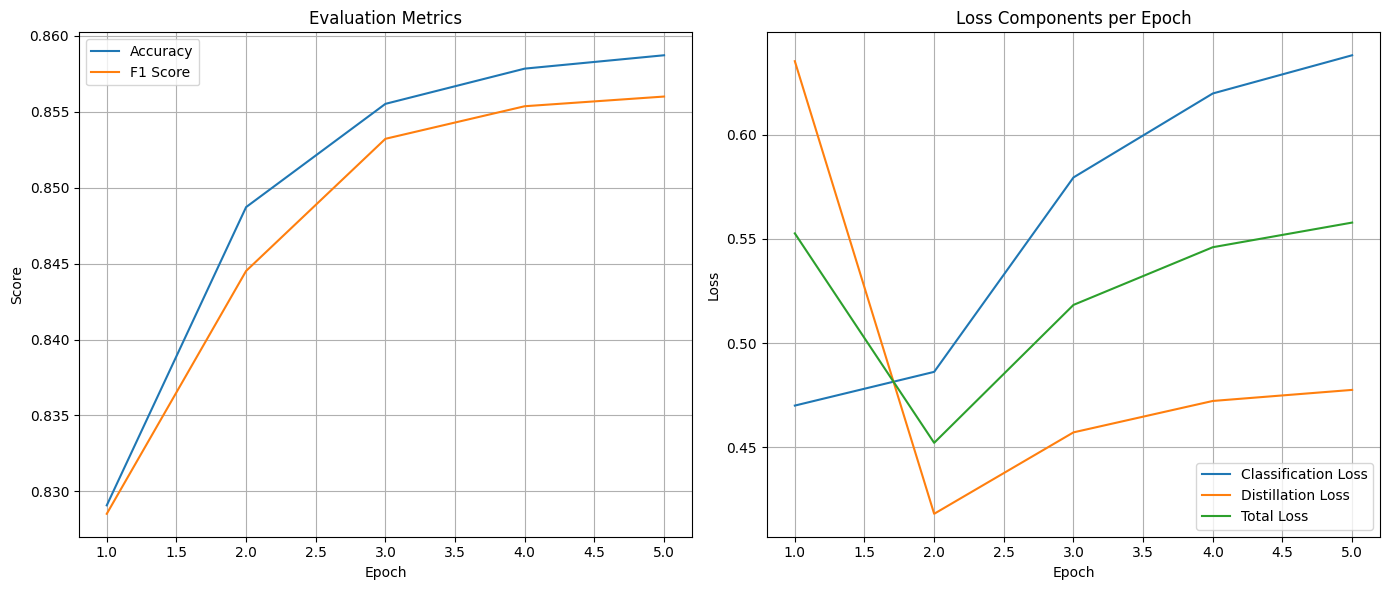

Saved plot to: /content/drive/MyDrive/distilled_bert_tiny_KLD_temp20/metrics_and_losses.png


In [ ]:
# Install packages
!pip install datasets matplotlib

# Import libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import os
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    BertModel, BertConfig, PreTrainedModel,
    Trainer, TrainingArguments
)
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset and tokenizer
dataset = load_dataset('imdb')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Load teacher model
teacher_model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/fine_tuned_bert").to(device)

# Define custom student model
class CustomBertStudentModel(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

# Student model config
student_config = BertConfig(
    hidden_size=312,
    num_hidden_layers=4,
    num_attention_heads=6,
    intermediate_size=1024,
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

student_model = CustomBertStudentModel(student_config).to(device)

# Metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Custom DistillationTrainer
class DistillationTrainer(Trainer):
    def __init__(self, teacher_model, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        self.alpha = alpha
        self.temperature = temperature
        self.teacher_model.eval()
        self.loss_tracker = {'epoch': [], 'classification_loss': [], 'distillation_loss': [], 'total_loss': []}

    def compute_loss(self, model, inputs, return_outputs=False):
        student_outputs = model(**inputs)
        student_logits = student_outputs.logits

        with torch.no_grad():
            teacher_outputs = self.teacher_model(**inputs)
            teacher_logits = teacher_outputs.logits

        labels = inputs['labels']
        hard_loss = nn.CrossEntropyLoss()(student_logits, labels)

        T = self.temperature
        soft_loss = nn.KLDivLoss(reduction="batchmean")(
            torch.nn.functional.log_softmax(student_logits / T, dim=-1),
            torch.nn.functional.softmax(teacher_logits / T, dim=-1)
        ) * (T * T)

        total_loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss

        # Logging per epoch
        if self.state.epoch is not None:
            current_epoch = int(self.state.epoch)
            if current_epoch > len(self.loss_tracker['epoch']):
                self.loss_tracker['epoch'].append(current_epoch)
                self.loss_tracker['classification_loss'].append(hard_loss.item())
                self.loss_tracker['distillation_loss'].append(soft_loss.item())
                self.loss_tracker['total_loss'].append(total_loss.item())

        return (total_loss, student_outputs) if return_outputs else total_loss

# Training arguments
training_args = TrainingArguments(
    output_dir="./kd_bert_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    metric_for_best_model="accuracy"
)

# Trainer setup
trainer = DistillationTrainer(
    model=student_model,
    teacher_model=teacher_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
    alpha=0.5,
    temperature=20.0
)

# Train
print("\nStarting Knowledge Distillation Training...\n")
train_result = trainer.train()
print("\nTraining Complete. Evaluating...\n")
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

# Save student model and tokenizer
save_path = "/content/drive/MyDrive/distilled_bert_tiny_KLD_temp20"
student_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"\nStudent model saved to: {save_path}")

# Save loss CSV
loss_df = pd.DataFrame(trainer.loss_tracker)
csv_path = os.path.join(save_path, "loss_per_epoch.csv")
loss_df.to_csv(csv_path, index=False)
print(f"Saved loss table to: {csv_path}")
print("\nLoss Table:\n", loss_df.to_string(index=False))

# PlottingW
logs = trainer.state.log_history
epochs, accs, f1s = [], [], []
for log in logs:
    if 'eval_accuracy' in log:
        epochs.append(log['epoch'])
        accs.append(log['eval_accuracy'])
        f1s.append(log['eval_f1'])

plt.figure(figsize=(14, 6))

# Evaluation Metrics
plt.subplot(1, 2, 1)
plt.plot(epochs, accs, label='Accuracy')
plt.plot(epochs, f1s, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.legend()
plt.grid(True)

# Losses
plt.subplot(1, 2, 2)
plt.plot(loss_df['epoch'], loss_df['classification_loss'], label='Classification Loss')
plt.plot(loss_df['epoch'], loss_df['distillation_loss'], label='Distillation Loss')
plt.plot(loss_df['epoch'], loss_df['total_loss'], label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Components per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plot_path = os.path.join(save_path, "metrics_and_losses.png")
plt.savefig(plot_path)
plt.show()
print(f"Saved plot to: {plot_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Starting Knowledge Distillation Training...



/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.615200,0.835302,0.827680,0.823370,0.844491,0.803280
2,0.763400,0.703213,0.849360,0.846998,0.860492,0.833920
3,0.615700,0.677914,0.854480,0.851425,0.869681,0.833920
4,0.541000,0.693904,0.858880,0.859900,0.853730,0.866160
5,0.497100,0.700659,0.859360,0.858648,0.863019,0.854320



Training Complete. Evaluating...


Student model saved to: /content/drive/MyDrive/distilled_bert_tiny_KLD_temp30
Saved loss table to: /content/drive/MyDrive/distilled_bert_tiny_KLD_temp30/loss_per_epoch.csv

Loss Table:
  epoch  classification_loss  distillation_loss  total_loss
     1             0.457326           0.396972    0.427149
     2             0.550800           0.407040    0.478920
     3             0.564271           0.396831    0.480551
     4             0.667938           0.519170    0.593554
     5             0.667428           0.491081    0.579254


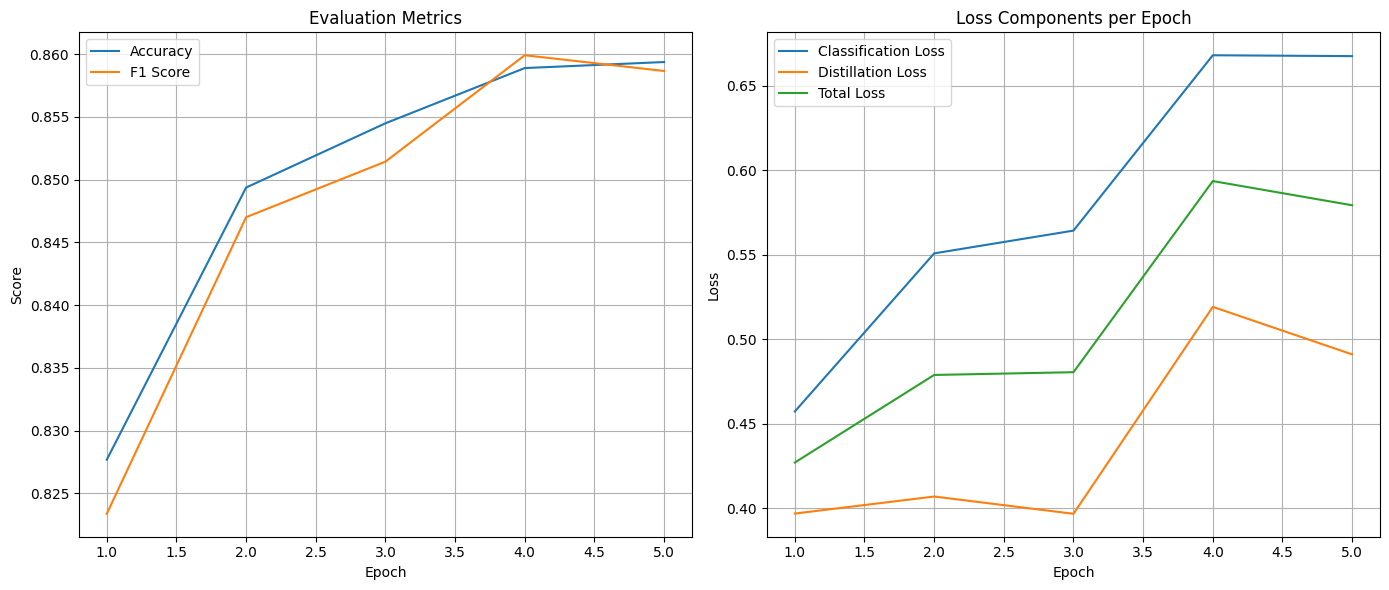

Saved plot to: /content/drive/MyDrive/distilled_bert_tiny_KLD_temp30/metrics_and_losses.png


In [ ]:
# Import libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import os
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    BertModel, BertConfig, PreTrainedModel,
    Trainer, TrainingArguments
)
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset and tokenizer
dataset = load_dataset('imdb')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Load teacher model
teacher_model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/fine_tuned_bert").to(device)

# Define custom student model
class CustomBertStudentModel(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

# Student model config
student_config = BertConfig(
    hidden_size=312,
    num_hidden_layers=4,
    num_attention_heads=6,
    intermediate_size=1024,
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

student_model = CustomBertStudentModel(student_config).to(device)

# Metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Custom DistillationTrainer
class DistillationTrainer(Trainer):
    def __init__(self, teacher_model, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        self.alpha = alpha
        self.temperature = temperature
        self.teacher_model.eval()
        self.loss_tracker = {'epoch': [], 'classification_loss': [], 'distillation_loss': [], 'total_loss': []}

    def compute_loss(self, model, inputs, return_outputs=False):
        student_outputs = model(**inputs)
        student_logits = student_outputs.logits

        with torch.no_grad():
            teacher_outputs = self.teacher_model(**inputs)
            teacher_logits = teacher_outputs.logits

        labels = inputs['labels']
        hard_loss = nn.CrossEntropyLoss()(student_logits, labels)

        T = self.temperature
        soft_loss = nn.KLDivLoss(reduction="batchmean")(
            torch.nn.functional.log_softmax(student_logits / T, dim=-1),
            torch.nn.functional.softmax(teacher_logits / T, dim=-1)
        ) * (T * T)

        total_loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss

        # Logging per epoch
        if self.state.epoch is not None:
            current_epoch = int(self.state.epoch)
            if current_epoch > len(self.loss_tracker['epoch']):
                self.loss_tracker['epoch'].append(current_epoch)
                self.loss_tracker['classification_loss'].append(hard_loss.item())
                self.loss_tracker['distillation_loss'].append(soft_loss.item())
                self.loss_tracker['total_loss'].append(total_loss.item())

        return (total_loss, student_outputs) if return_outputs else total_loss

# Training arguments
training_args = TrainingArguments(
    output_dir="./kd_bert_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    metric_for_best_model="accuracy"
)

# Trainer setup
trainer = DistillationTrainer(
    model=student_model,
    teacher_model=teacher_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
    alpha=0.5,
    temperature=30.0
)

# Train
print("\nStarting Knowledge Distillation Training...\n")
train_result = trainer.train()
print("\nTraining Complete. Evaluating...\n")
# eval_results = trainer.evaluate()
# print(f"Evaluation Results: {eval_results}")

# Save student model and tokenizer
save_path = "/content/drive/MyDrive/distilled_bert_tiny_KLD_temp30"
student_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"\nStudent model saved to: {save_path}")

# Save loss CSV
loss_df = pd.DataFrame(trainer.loss_tracker)
csv_path = os.path.join(save_path, "loss_per_epoch.csv")
loss_df.to_csv(csv_path, index=False)
print(f"Saved loss table to: {csv_path}")
print("\nLoss Table:\n", loss_df.to_string(index=False))

# PlottingW
logs = trainer.state.log_history
epochs, accs, f1s = [], [], []
for log in logs:
    if 'eval_accuracy' in log:
        epochs.append(log['epoch'])
        accs.append(log['eval_accuracy'])
        f1s.append(log['eval_f1'])

plt.figure(figsize=(14, 6))

# Evaluation Metrics
plt.subplot(1, 2, 1)
plt.plot(epochs, accs, label='Accuracy')
plt.plot(epochs, f1s, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.legend()
plt.grid(True)

# Losses
plt.subplot(1, 2, 2)
plt.plot(loss_df['epoch'], loss_df['classification_loss'], label='Classification Loss')
plt.plot(loss_df['epoch'], loss_df['distillation_loss'], label='Distillation Loss')
plt.plot(loss_df['epoch'], loss_df['total_loss'], label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Components per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plot_path = os.path.join(save_path, "metrics_and_losses.png")
plt.savefig(plot_path)
plt.show()
print(f"Saved plot to: {plot_path}")


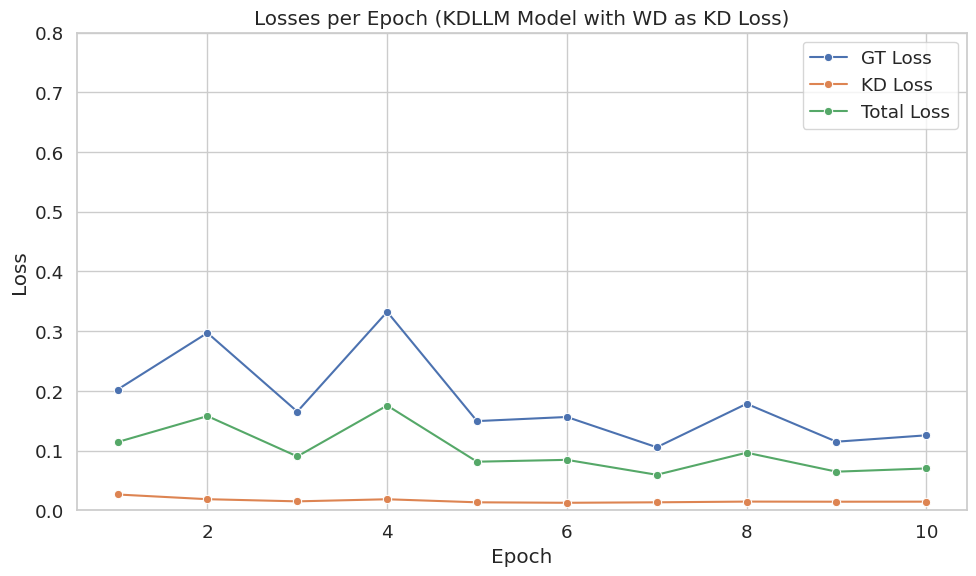

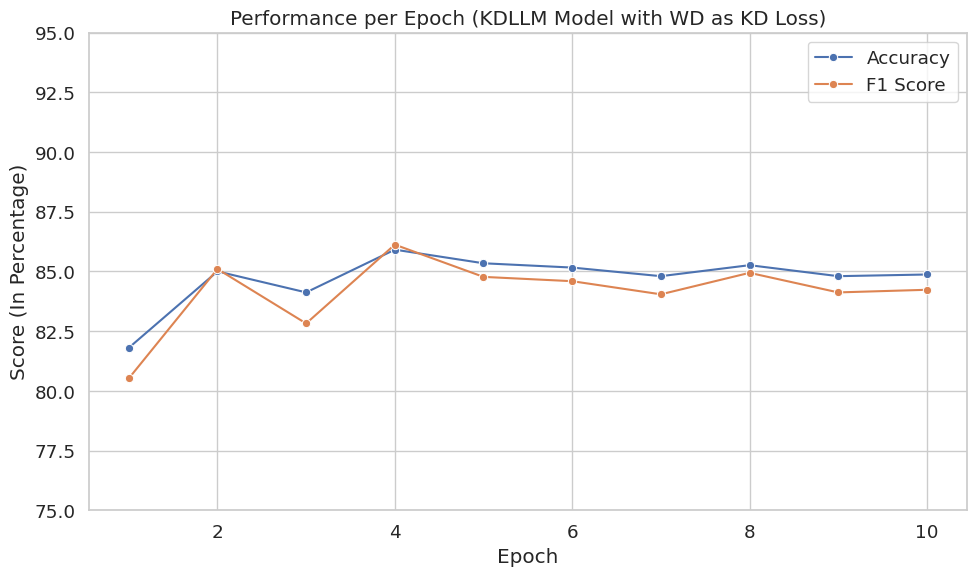

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data from your LaTeX table
data = {
    "Epoch": list(range(1, 11)),
    "GT Loss": [0.2021, 0.2970, 0.1652, 0.3323, 0.1493, 0.1562, 0.1055, 0.1783, 0.1148, 0.1255],
    "KD Loss": [0.0264, 0.0185, 0.0149, 0.0184, 0.0133, 0.0125, 0.0133, 0.0145, 0.0143, 0.0144],
    "Total Loss": [0.1142, 0.1577, 0.0901, 0.1754, 0.0813, 0.0844, 0.0594, 0.0964, 0.0646, 0.0700],
    "Accuracy": [x*100 for x in[0.8180, 0.8500, 0.8412, 0.8591, 0.8534, 0.8516, 0.8480, 0.8526, 0.8480, 0.8487]],
    "F1": [x*100 for x in [0.8052, 0.8510, 0.8282, 0.8612, 0.8477, 0.8459, 0.8404, 0.8494, 0.8412, 0.8423]],
}


df = pd.DataFrame(data)
sns.set(style="whitegrid", font_scale=1.2)

# Loss Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x="Epoch", y="GT Loss", data=df, marker="o", label="GT Loss")
sns.lineplot(x="Epoch", y="KD Loss", data=df, marker="o", label="KD Loss")
sns.lineplot(x="Epoch", y="Total Loss", data=df, marker="o", label="Total Loss")
plt.title("Losses per Epoch (KDLLM Model with WD as KD Loss)")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.ylim(0, 0.8)
plt.legend()
plt.tight_layout()
plt.show()

# Performance Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x="Epoch", y="Accuracy", data=df, marker="o", label="Accuracy")
sns.lineplot(x="Epoch", y="F1", data=df, marker="o", label="F1 Score")
plt.title("Performance per Epoch (KDLLM Model with WD as KD Loss)")
plt.ylabel("Score (In Percentage)")
plt.xlabel("Epoch")
plt.ylim(75, 95)
plt.legend()
plt.tight_layout()
plt.show()

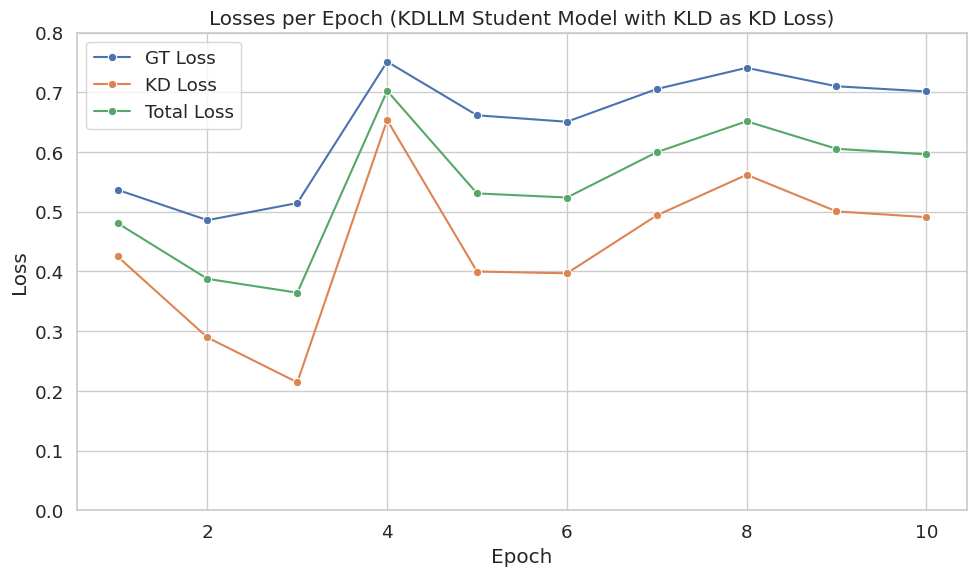

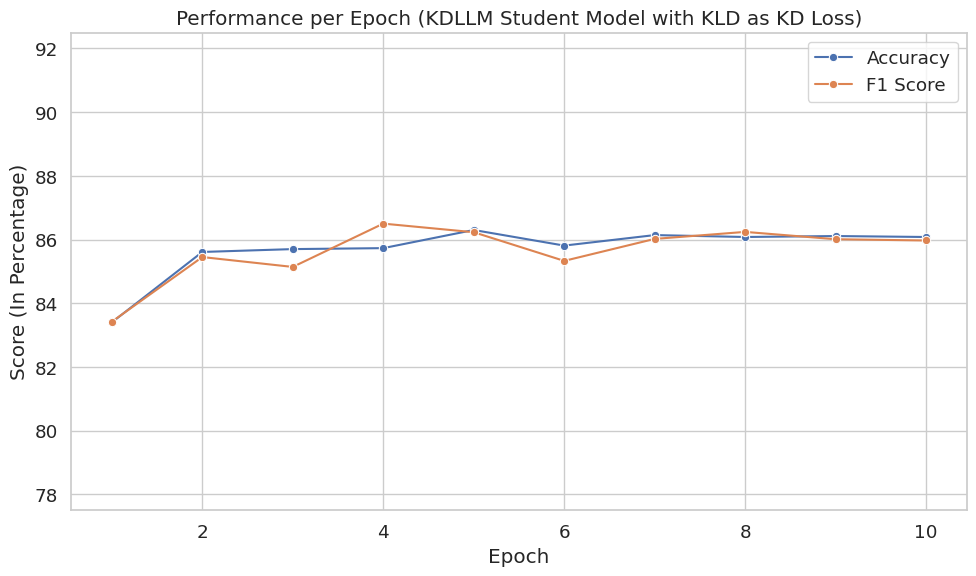

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data from the LaTeX table (KLD Loss experiment)
data = {
    "Epoch": list(range(1, 11)),
    "GT Loss": [0.5366, 0.4858, 0.5144, 0.7512, 0.6614, 0.6506, 0.7054, 0.7409, 0.7100, 0.7013],
    "KD Loss": [0.4250, 0.2893, 0.2142, 0.6534, 0.3998, 0.3968, 0.4938, 0.5618, 0.5005, 0.4908],
    "Total Loss": [0.4808, 0.3875, 0.3643, 0.7023, 0.5306, 0.5237, 0.5996, 0.6514, 0.6053, 0.5960],
    "Accuracy": [x * 100 for x in [0.8340, 0.8561, 0.8570, 0.8573, 0.8630, 0.8581, 0.8614, 0.8608, 0.8611, 0.8608]],
    "F1": [x * 100 for x in [0.8342, 0.8545, 0.8514, 0.8650, 0.8623, 0.8533, 0.8602, 0.8624, 0.8601, 0.8597]],
}



df = pd.DataFrame(data)
sns.set(style="whitegrid", font_scale=1.2)

# Loss Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x="Epoch", y="GT Loss", data=df, marker="o", label="GT Loss")
sns.lineplot(x="Epoch", y="KD Loss", data=df, marker="o", label="KD Loss")
sns.lineplot(x="Epoch", y="Total Loss", data=df, marker="o", label="Total Loss")
plt.title("Losses per Epoch (KDLLM Student Model with KLD as KD Loss)")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.ylim(0, 0.8)
plt.legend()
plt.tight_layout()
plt.show()

# Performance Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x="Epoch", y="Accuracy", data=df, marker="o", label="Accuracy")
sns.lineplot(x="Epoch", y="F1", data=df, marker="o", label="F1 Score")
plt.title("Performance per Epoch (KDLLM Student Model with KLD as KD Loss)")
plt.ylabel("Score (In Percentage)")
plt.xlabel("Epoch")
plt.ylim(77.5, 92.5)
# plt.ylim(0, 1)  # Full 0 to 1 range as requested
plt.legend()
plt.tight_layout()
plt.show()


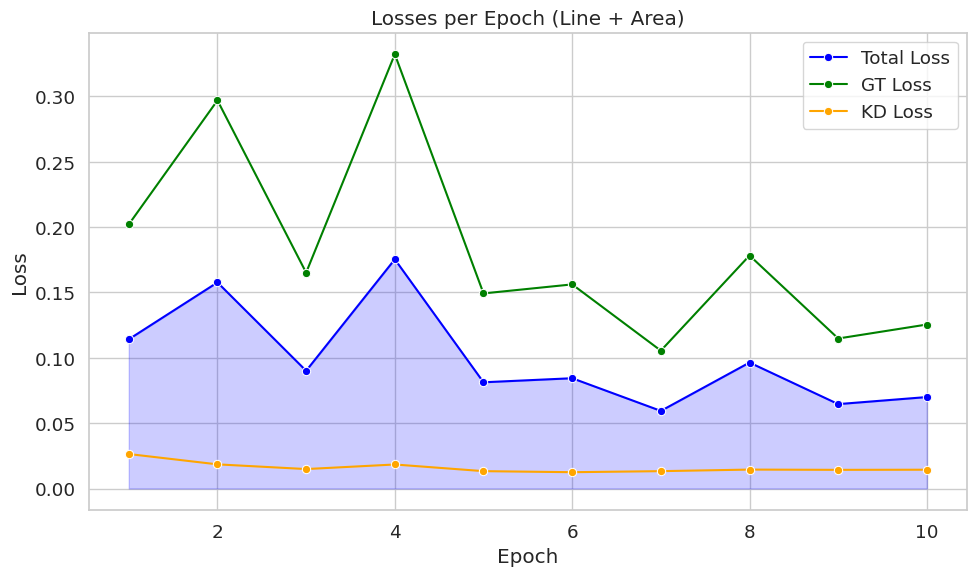

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="Epoch", y="Total Loss", data=df, marker="o", label="Total Loss", color="blue")
plt.fill_between(df["Epoch"], df["Total Loss"], alpha=0.2, color="blue")
sns.lineplot(x="Epoch", y="GT Loss", data=df, marker="o", label="GT Loss", color="green")
sns.lineplot(x="Epoch", y="KD Loss", data=df, marker="o", label="KD Loss", color="orange")
plt.title("Losses per Epoch (Line + Area)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

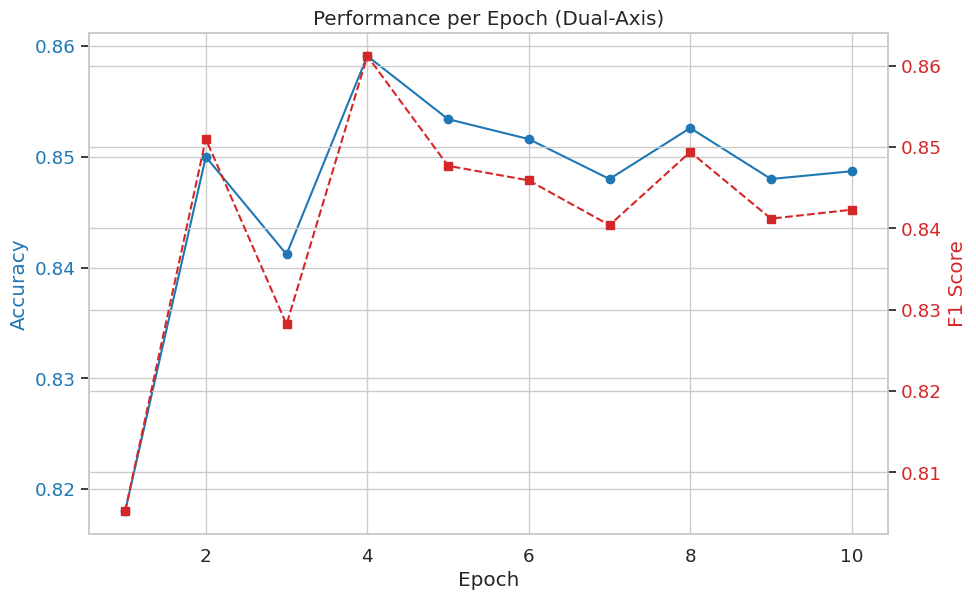

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(df["Epoch"], df["Accuracy"], color=color, marker="o", label="Accuracy")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('F1 Score', color=color)
ax2.plot(df["Epoch"], df["F1"], color=color, marker="s", linestyle='--', label="F1 Score")
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Performance per Epoch (Dual-Axis)")
plt.show()


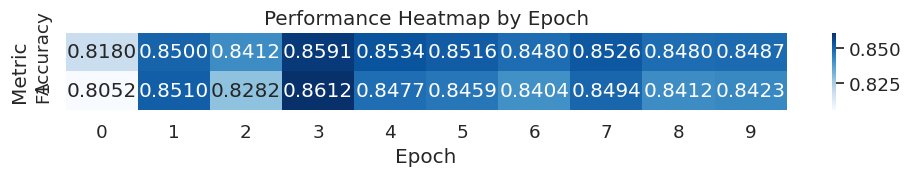

In [ ]:
perf_data = df[["Accuracy", "F1"]].T
plt.figure(figsize=(10, 2))
sns.heatmap(perf_data, annot=True, cmap="Blues", cbar=True, fmt=".4f")
plt.title("Performance Heatmap by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()


<ipython-input-6-6bafe35096ec>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='Set2')


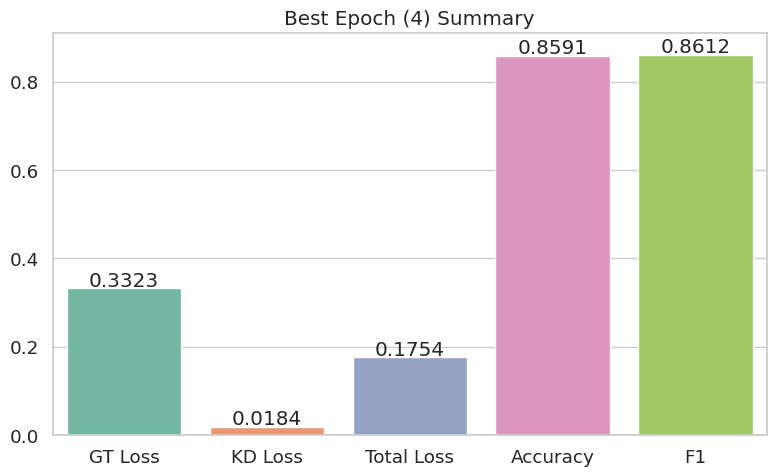

In [ ]:
best_epoch = df.loc[df["F1"].idxmax()]
plt.figure(figsize=(8, 5))
metrics = ['GT Loss', 'KD Loss', 'Total Loss', 'Accuracy', 'F1']
values = [best_epoch[m] for m in metrics]
sns.barplot(x=metrics, y=values, palette='Set2')
plt.title(f"Best Epoch ({int(best_epoch['Epoch'])}) Summary")
for i, v in enumerate(values):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center')
plt.ylim(0, max(values) + 0.05)
plt.tight_layout()
plt.show()


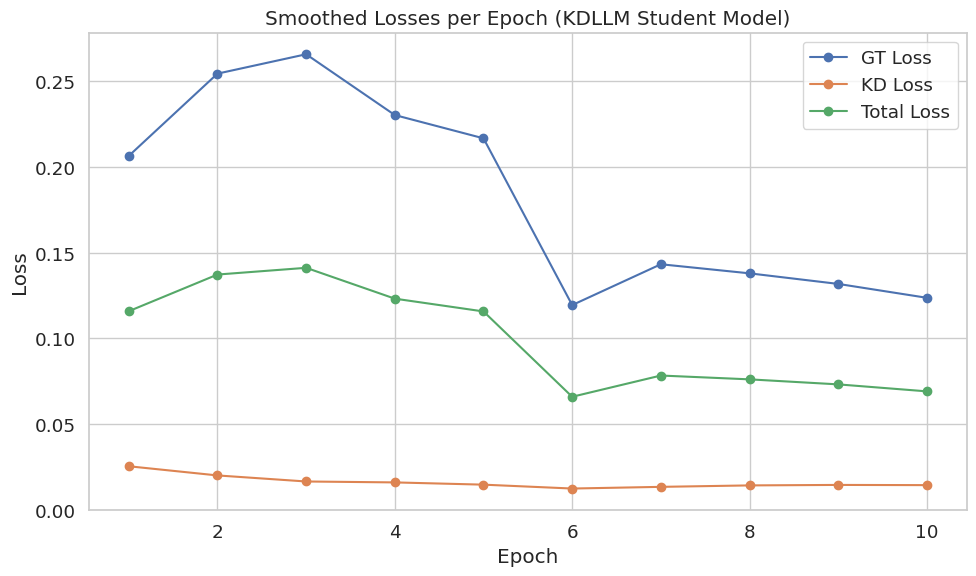

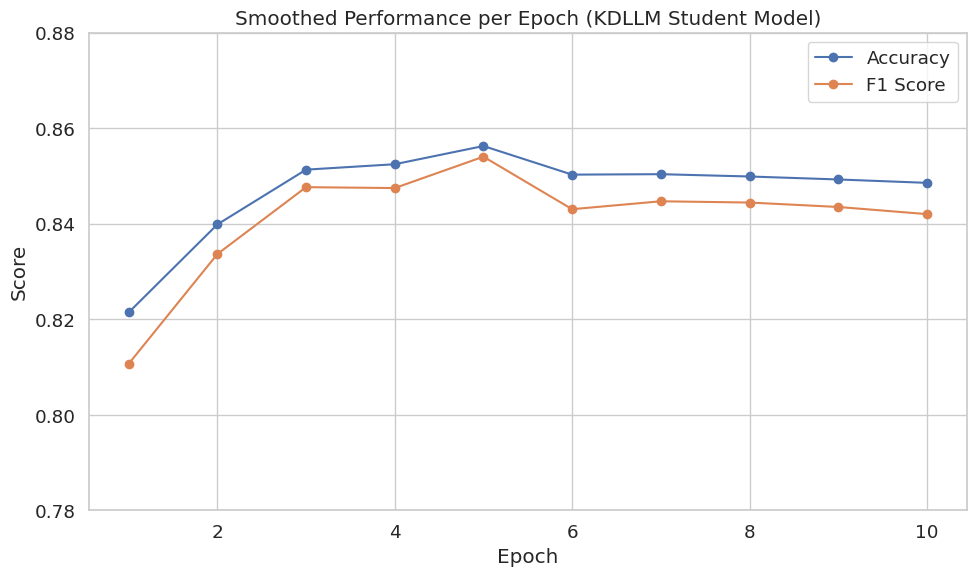

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.signal import savgol_filter

# Data from your LaTeX table
data = {
    "Epoch": list(range(1, 11)),
    "GT Loss": [0.2021, 0.2970, 0.1652, 0.3323, 0.1493, 0.1562, 0.1055, 0.1783, 0.1148, 0.1255],
    "KD Loss": [0.0264, 0.0185, 0.0149, 0.0184, 0.0133, 0.0125, 0.0133, 0.0145, 0.0143, 0.0144],
    "Total Loss": [0.1142, 0.1577, 0.0901, 0.1754, 0.0813, 0.0844, 0.0594, 0.0964, 0.0646, 0.0700],
    "Accuracy": [0.8180, 0.8500, 0.8412, 0.8591, 0.8534, 0.8516, 0.8480, 0.8526, 0.8480, 0.8487],
    "F1": [0.8052, 0.8510, 0.8282, 0.8612, 0.8477, 0.8459, 0.8404, 0.8494, 0.8412, 0.8423],
}

df = pd.DataFrame(data)

# Apply Savitzky-Golay smoothing
window_size = 5  # must be odd and <= number of points
poly_order = 2

for key in ["GT Loss", "KD Loss", "Total Loss", "Accuracy", "F1"]:
    df[f"{key} Smoothed"] = savgol_filter(df[key], window_length=window_size, polyorder=poly_order)

sns.set(style="whitegrid", font_scale=1.2)

# Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(df["Epoch"], df["GT Loss Smoothed"], label="GT Loss", marker="o")
plt.plot(df["Epoch"], df["KD Loss Smoothed"], label="KD Loss", marker="o")
plt.plot(df["Epoch"], df["Total Loss Smoothed"], label="Total Loss", marker="o")
plt.title("Smoothed Losses per Epoch (KDLLM Student Model)")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.tight_layout()
plt.show()

# Performance Plot
plt.figure(figsize=(10, 6))
plt.plot(df["Epoch"], df["Accuracy Smoothed"], label="Accuracy", marker="o")
plt.plot(df["Epoch"], df["F1 Smoothed"], label="F1 Score", marker="o")
plt.title("Smoothed Performance per Epoch (KDLLM Student Model)")
plt.ylabel("Score")
plt.xlabel("Epoch")
plt.ylim(0.78, 0.88)
plt.legend()
plt.tight_layout()
plt.show()


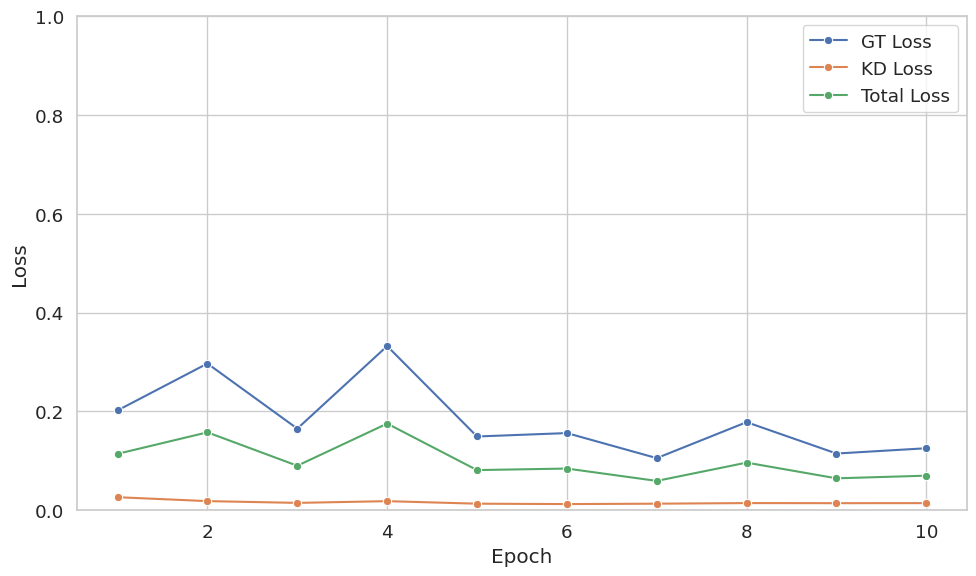

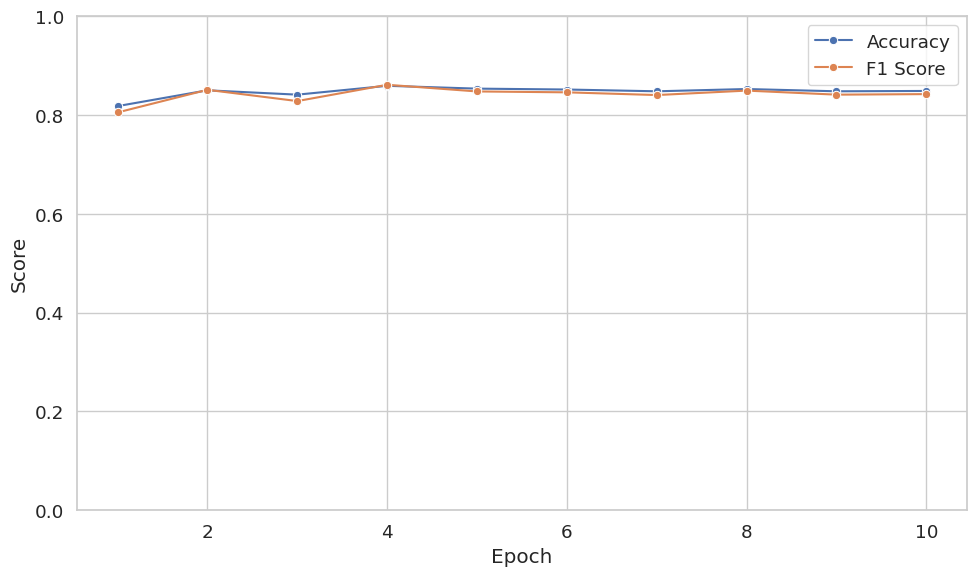

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Original data
data = {
    "Epoch": list(range(1, 11)),
    "GT Loss": [0.2021, 0.2970, 0.1652, 0.3323, 0.1493, 0.1562, 0.1055, 0.1783, 0.1148, 0.1255],
    "KD Loss": [0.0264, 0.0185, 0.0149, 0.0184, 0.0133, 0.0125, 0.0133, 0.0145, 0.0143, 0.0144],
    "Total Loss": [0.1142, 0.1577, 0.0901, 0.1754, 0.0813, 0.0844, 0.0594, 0.0964, 0.0646, 0.0700],
    "Accuracy": [0.8180, 0.8500, 0.8412, 0.8591, 0.8534, 0.8516, 0.8480, 0.8526, 0.8480, 0.8487],
    "F1": [0.8052, 0.8510, 0.8282, 0.8612, 0.8477, 0.8459, 0.8404, 0.8494, 0.8412, 0.8423],
}

df = pd.DataFrame(data)
sns.set(style="whitegrid", font_scale=1.2)

# === Loss Plot ===
plt.figure(figsize=(10, 6))
sns.lineplot(x="Epoch", y="GT Loss", data=df, marker="o", label="GT Loss")
sns.lineplot(x="Epoch", y="KD Loss", data=df, marker="o", label="KD Loss")
sns.lineplot(x="Epoch", y="Total Loss", data=df, marker="o", label="Total Loss")
# plt.title("Loss per Epoch (KDLLM Student Model)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

# === Performance Plot ===
plt.figure(figsize=(10, 6))
sns.lineplot(x="Epoch", y="Accuracy", data=df, marker="o", label="Accuracy")
sns.lineplot(x="Epoch", y="F1", data=df, marker="o", label="F1 Score")
# plt.title("Performance per Epoch (KDLLM Student Model)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


92.4
81.61
69.83
86.3
85.91


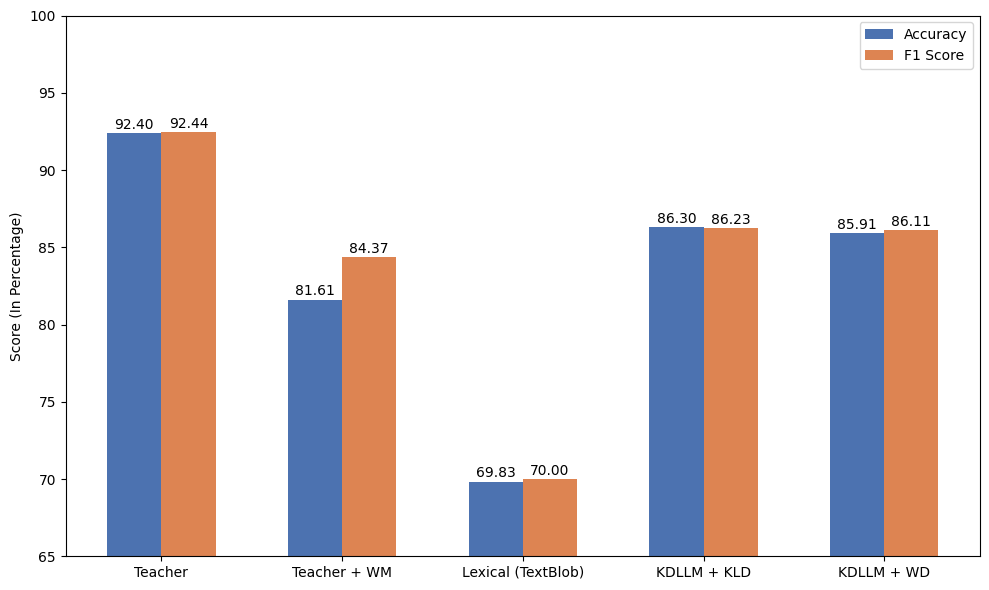

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = [
    "Teacher",
    "Teacher + WM",
    "Lexical (TextBlob)",
    "KDLLM + KLD",
    "KDLLM + WD"
]

# Accuracy and F1 scores
accuracy = [0.9240, 0.8161, 0.6983, 0.8630, 0.85908]
f1_score = [0.9244, 0.8437, 0.7000, 0.8623, 0.8611]

for i in range(0,5):
  accuracy[i] = round(accuracy[i]*100,2)
  f1_score[i] = round(f1_score[i]*100,2)
  print(accuracy[i])

# Bar settings
x = np.arange(len(models))
width = 0.3

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy', color='#4C72B0')
bars2 = ax.bar(x + width/2, f1_score, width, label='F1 Score', color='#DD8452')

# Labels and title
ax.set_ylabel('Score (In Percentage)')
# ax.set_title('Accuracy and F1 Score Comparison of Models')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=0)
ax.set_ylim(65, 100)
ax.legend()

# Add value labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 1),  # offset text by 3 points
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

# Display
plt.tight_layout()
plt.show()


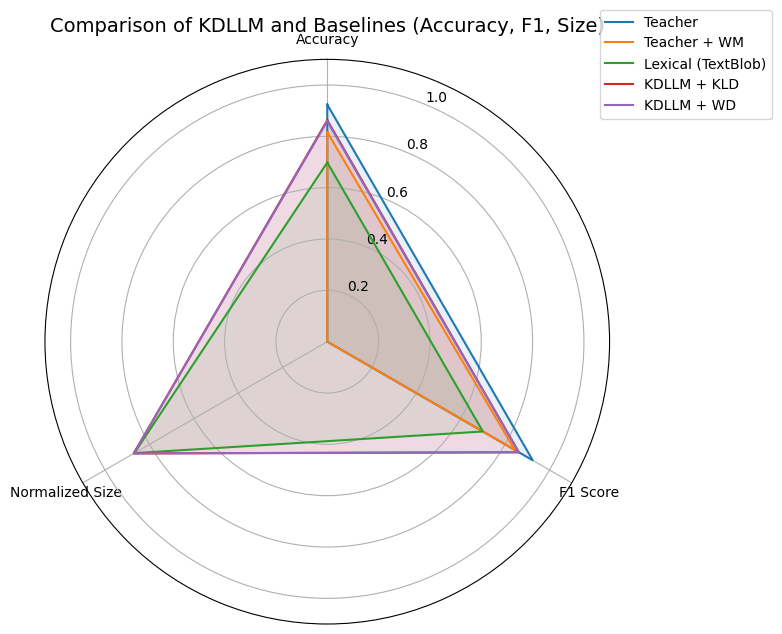

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for each model: Accuracy, F1 Score, Model Size (MB)
models = {
    "Teacher": [0.9240, 0.9244, 418],
    "Teacher + WM": [0.8161, 0.8437, 418],
    "Lexical (TextBlob)": [0.6983, 0.7000, 55],
    "KDLLM + KLD": [0.8630, 0.8623, 54],
    "KDLLM + WD": [0.85908, 0.8611, 54]
}

# Normalize model size (smaller is better → invert)
max_size = max(model[2] for model in models.values())
for key in models:
    models[key][2] = 1 - (models[key][2] / max_size)

# Labels for axes
labels = ['Accuracy', 'F1 Score', 'Normalized Size']
num_vars = len(labels)

# Radar chart setup
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each model
for name, scores in models.items():
    data = scores + scores[:1]  # close the loop
    ax.plot(angles, data, label=name)
    ax.fill(angles, data, alpha=0.1)

# Formatting
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 1.1)
ax.set_title("Comparison of KDLLM and Baselines (Accuracy, F1, Size)", fontsize=14, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()


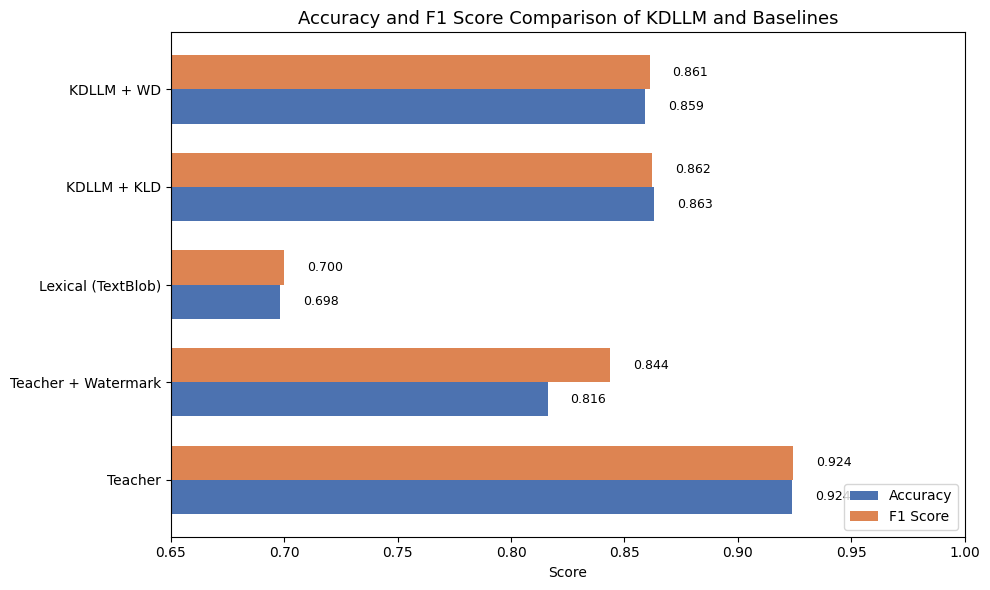

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = [
    "Teacher",
    "Teacher + Watermark",
    "Lexical (TextBlob)",
    "KDLLM + KLD",
    "KDLLM + WD"
]

accuracy = [0.9240, 0.8161, 0.6983, 0.8630, 0.85908]
f1_score = [0.9244, 0.8437, 0.7000, 0.8623, 0.8611]

# Settings
y = np.arange(len(models))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars with new colors
bars1 = ax.barh(y - bar_width/2, accuracy, height=bar_width, label='Accuracy', color='#4C72B0')  # muted blue
bars2 = ax.barh(y + bar_width/2, f1_score, height=bar_width, label='F1 Score', color='#DD8452')  # warm orange

# Annotate bars
def add_labels(bars):
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', va='center', ha='left', fontsize=9)

add_labels(bars1)
add_labels(bars2)

# Axes and labels
ax.set_yticks(y)
ax.set_yticklabels(models)
ax.set_xlabel('Score')
ax.set_xlim(0.65, 1.0)
ax.set_title('Accuracy and F1 Score Comparison of KDLLM and Baselines', fontsize=13)
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()


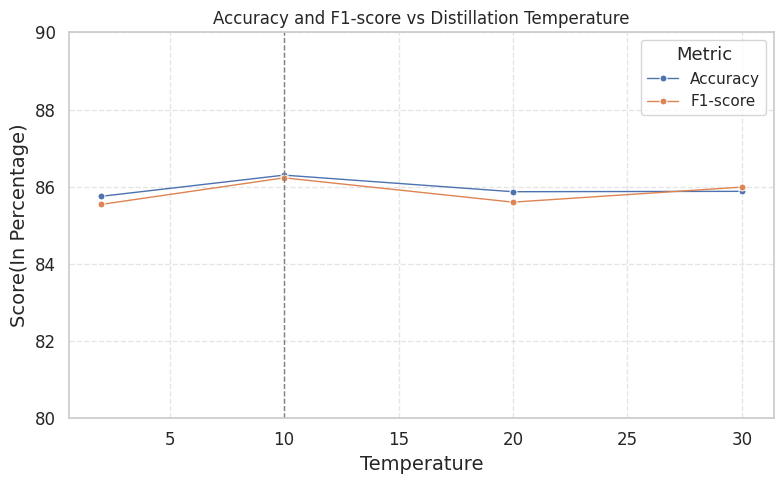

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data
temps = [2, 10, 20, 30]
accuracy = [0.8575,  0.8630, 0.8587, 0.8588]
f1_score = [0.8554, 0.8623, 0.8560, 0.8599]
for i in range(0,4):
  accuracy[i] = accuracy[i]*100
  f1_score[i] = f1_score[i]*100

# temps = [1, 2, 5, 10, 20, 30]
# accuracy = [0.8420, 0.8480, 0.8578, 0.8630, 0.8542, 0.8508]
# f1_score = [0.8400, 0.8450, 0.8570, 0.8623, 0.8517, 0.8481]
#

# Set Seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(8, 5))

# Plot Accuracy and F1-score
sns.lineplot(x=temps, y=accuracy, marker='o', label='Accuracy', linewidth=1, markersize=5)
sns.lineplot(x=temps, y=f1_score, marker='o', label='F1-score', linewidth=1, markersize=5)

# Highlight Temp = 10
plt.axvline(x=10, color='gray', linestyle='--', linewidth=1)
plt.scatter([10], [0.8630], color='dodgerblue', s=20, zorder=5)
plt.scatter([10], [0.8623], color='forestgreen', s=20, zorder=5)

# Customize the plot
plt.title('Accuracy and F1-score vs Distillation Temperature')
plt.xlabel('Temperature', fontsize=14)
plt.ylabel('Score(In Percentage)', fontsize=14)
plt.ylim(80, 90)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines and make the layout tight
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Add legend
plt.legend(title='Metric', title_fontsize='13', loc='upper right')

# Show the plot
plt.show()


In [ ]:
# === INSTALL REQUIRED LIBRARIES ===
!pip install torch transformers google-colab ptflops

# === IMPORT LIBRARIES ===
import time
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
from ptflops import get_model_complexity_info
from google.colab import drive

# === MOUNT GOOGLE DRIVE ===
drive.mount('/content/drive')

# === DEVICE SETUP ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === MODEL PATH ===
model_path = '/content/drive/MyDrive/fine_tuned_bert'  # Adjust if needed

# === LOAD MODEL & TOKENIZER ===
model = BertForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer = BertTokenizer.from_pretrained(model_path)
model.eval()

# === SAMPLE INPUT ===
input_text = "This is an example sentence."
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

# === WARM-UP ===
for _ in range(10):
    with torch.no_grad():
        _ = model(**inputs)

# === MEASURE INFERENCE LATENCY ===
start_time = time.time()
with torch.no_grad():
    _ = model(**inputs)
end_time = time.time()

latency = end_time - start_time
print(f"\nInference Latency: {latency*1000:.2f} ms")

# === MEASURE THROUGHPUT ===
num_inferences = 100
start_time = time.time()
with torch.no_grad():
    for _ in range(num_inferences):
        _ = model(**inputs)
end_time = time.time()

total_time = end_time - start_time
throughput = num_inferences / total_time
print(f"Throughput: {throughput:.2f} inferences/second")

# === MEASURE FLOPs & PARAMS ===
# Define input_constructor for ptflops
def input_constructor(input_res):
    return {
        'input_ids': torch.ones(1, input_res[1], dtype=torch.long).to(device),
        'attention_mask': torch.ones(1, input_res[1], dtype=torch.long).to(device)
    }

try:
    print("\nCalculating FLOPs and Parameters (this may take a minute)...")
    flops, params = get_model_complexity_info(
        model,
        input_res=(1, 512),
        input_constructor=input_constructor,
        as_strings=True,
        print_per_layer_stat=False,
        verbose=False
    )
    print(f"FLOPs: {flops}")
    print(f"Number of Parameters: {params}")
except Exception as e:
    print(f"Error calculating FLOPs: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu

Inference Latency: 165.93 ms
Throughput: 4.97 inferences/second

Calculating FLOPs and Parameters (this may take a minute)...
Warning! No positional inputs found for a module, assuming batch size is 1.
FLOPs: 43.54 GMac
Number of Parameters: 109.48 M


In [ ]:
# === INSTALL REQUIRED LIBRARIES ===
!pip install torch transformers google-colab ptflops

# === IMPORT LIBRARIES ===
import time
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
from ptflops import get_model_complexity_info
from google.colab import drive

# === MOUNT GOOGLE DRIVE ===
drive.mount('/content/drive')

# === DEVICE SETUP ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === MODEL PATH ===
model_path = '/content/drive/MyDrive/watermarked_bert/'  # Adjust if needed

# === LOAD MODEL & TOKENIZER ===
model = BertForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer = BertTokenizer.from_pretrained(model_path)
model.eval()

# === SAMPLE INPUT ===
input_text = "This is an example sentence."
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

# === WARM-UP ===
for _ in range(10):
    with torch.no_grad():
        _ = model(**inputs)

# === MEASURE INFERENCE LATENCY ===
start_time = time.time()
with torch.no_grad():
    _ = model(**inputs)
end_time = time.time()

latency = end_time - start_time
print(f"\nInference Latency: {latency*1000:.2f} ms")

# === MEASURE THROUGHPUT ===
num_inferences = 100
start_time = time.time()
with torch.no_grad():
    for _ in range(num_inferences):
        _ = model(**inputs)
end_time = time.time()

total_time = end_time - start_time
throughput = num_inferences / total_time
print(f"Throughput: {throughput:.2f} inferences/second")

# === MEASURE FLOPs & PARAMS ===
# Define input_constructor for ptflops
def input_constructor(input_res):
    return {
        'input_ids': torch.ones(1, input_res[1], dtype=torch.long).to(device),
        'attention_mask': torch.ones(1, input_res[1], dtype=torch.long).to(device)
    }

try:
    print("\nCalculating FLOPs and Parameters (this may take a minute)...")
    flops, params = get_model_complexity_info(
        model,
        input_res=(1, 512),
        input_constructor=input_constructor,
        as_strings=True,
        print_per_layer_stat=False,
        verbose=False
    )
    print(f"FLOPs: {flops}")
    print(f"Number of Parameters: {params}")
except Exception as e:
    print(f"Error calculating FLOPs: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu

Inference Latency: 135.10 ms
Throughput: 5.03 inferences/second

Calculating FLOPs and Parameters (this may take a minute)...
Warning! No positional inputs found for a module, assuming batch size is 1.
FLOPs: 43.54 GMac
Number of Parameters: 109.48 M


In [ ]:
# === INSTALL REQUIRED LIBRARIES ===
!pip install torch transformers google-colab ptflops

# === IMPORT LIBRARIES ===
import time
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
from ptflops import get_model_complexity_info
from google.colab import drive

# === MOUNT GOOGLE DRIVE ===
drive.mount('/content/drive')

# === DEVICE SETUP ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === MODEL PATH ===
model_path = '/content/drive/MyDrive/distilled_bert_tiny_WD_temp10/'  # Adjust if needed

# === LOAD MODEL & TOKENIZER ===
model = BertForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer = BertTokenizer.from_pretrained(model_path)
model.eval()

# === SAMPLE INPUT ===
input_text = "This is an example sentence."
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

# === WARM-UP ===
for _ in range(10):
    with torch.no_grad():
        _ = model(**inputs)

# === MEASURE INFERENCE LATENCY ===
start_time = time.time()
with torch.no_grad():
    _ = model(**inputs)
end_time = time.time()

latency = end_time - start_time
print(f"\nInference Latency: {latency*1000:.2f} ms")

# === MEASURE THROUGHPUT ===
num_inferences = 100
start_time = time.time()
with torch.no_grad():
    for _ in range(num_inferences):
        _ = model(**inputs)
end_time = time.time()

total_time = end_time - start_time
throughput = num_inferences / total_time
print(f"Throughput: {throughput:.2f} inferences/second")

# === MEASURE FLOPs & PARAMS ===
# Define input_constructor for ptflops
def input_constructor(input_res):
    return {
        'input_ids': torch.ones(1, input_res[1], dtype=torch.long).to(device),
        'attention_mask': torch.ones(1, input_res[1], dtype=torch.long).to(device)
    }

try:
    print("\nCalculating FLOPs and Parameters (this may take a minute)...")
    flops, params = get_model_complexity_info(
        model,
        input_res=(1, 512),
        input_constructor=input_constructor,
        as_strings=True,
        print_per_layer_stat=False,
        verbose=False
    )
    print(f"FLOPs: {flops}")
    print(f"Number of Parameters: {params}")
except Exception as e:
    print(f"Error calculating FLOPs: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu

Inference Latency: 7.08 ms
Throughput: 135.11 inferences/second

Calculating FLOPs and Parameters (this may take a minute)...
Warning! No positional inputs found for a module, assuming batch size is 1.
FLOPs: 2.11 GMac
Number of Parameters: 13.91 M


In [ ]:
# === INSTALL REQUIRED LIBRARIES ===
!pip install torch transformers google-colab ptflops

# === IMPORT LIBRARIES ===
import time
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
from ptflops import get_model_complexity_info
from google.colab import drive

# === MOUNT GOOGLE DRIVE ===
drive.mount('/content/drive')

# === DEVICE SETUP ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === MODEL PATH ===
model_path = '/content/drive/MyDrive/distilled_bert_tiny_KLD_temp20/'  # Adjust if needed

# === LOAD MODEL & TOKENIZER ===
model = BertForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer = BertTokenizer.from_pretrained(model_path)
model.eval()

# === SAMPLE INPUT ===
input_text = "This is an example sentence."
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

# === WARM-UP ===
for _ in range(10):
    with torch.no_grad():
        _ = model(**inputs)

# === MEASURE INFERENCE LATENCY ===
start_time = time.time()
with torch.no_grad():
    _ = model(**inputs)
end_time = time.time()

latency = end_time - start_time
print(f"\nInference Latency: {latency*1000:.2f} ms")

# === MEASURE THROUGHPUT ===
num_inferences = 100
start_time = time.time()
with torch.no_grad():
    for _ in range(num_inferences):
        _ = model(**inputs)
end_time = time.time()

total_time = end_time - start_time
throughput = num_inferences / total_time
print(f"Throughput: {throughput:.2f} inferences/second")

# === MEASURE FLOPs & PARAMS ===
# Define input_constructor for ptflops
def input_constructor(input_res):
    return {
        'input_ids': torch.ones(1, input_res[1], dtype=torch.long).to(device),
        'attention_mask': torch.ones(1, input_res[1], dtype=torch.long).to(device)
    }

try:
    print("\nCalculating FLOPs and Parameters (this may take a minute)...")
    flops, params = get_model_complexity_info(
        model,
        input_res=(1, 512),
        input_constructor=input_constructor,
        as_strings=True,
        print_per_layer_stat=False,
        verbose=False
    )
    print(f"FLOPs: {flops}")
    print(f"Number of Parameters: {params}")
except Exception as e:
    print(f"Error calculating FLOPs: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu

Inference Latency: 7.86 ms
Throughput: 134.09 inferences/second

Calculating FLOPs and Parameters (this may take a minute)...
Warning! No positional inputs found for a module, assuming batch size is 1.
FLOPs: 2.11 GMac
Number of Parameters: 13.91 M


In [ ]:
# Install required library
!pip install -q textblob

# Import libraries
from textblob import TextBlob
import time
import os
import importlib.util

# -------------------------------
# Function to measure inference latency
# -------------------------------
def measure_latency(text):
    # Warm-up
    _ = TextBlob(text).sentiment

    # Measure latency
    start_time = time.time()
    sentiment = TextBlob(text).sentiment
    end_time = time.time()

    latency = end_time - start_time
    print(f"Inference Latency: {latency:.6f} seconds")
    print(f"Sentiment Output: {sentiment}")
    return latency

# -------------------------------
# Function to measure throughput
# -------------------------------
def measure_throughput(text, num_sentences=100):
    start_time = time.time()
    for _ in range(num_sentences):
        _ = TextBlob(text).sentiment
    end_time = time.time()

    total_time = end_time - start_time
    throughput = num_sentences / total_time
    print(f"Throughput: {throughput:.2f} sentences/second")
    return throughput

# -------------------------------
# Function to estimate TextBlob module size
# -------------------------------
def get_module_size(module_name="textblob"):
    spec = importlib.util.find_spec(module_name)
    if spec and spec.origin:
        size = os.path.getsize(spec.origin)
        print(f"{module_name} main module size: {size / 1024:.2f} KB")
        return size
    else:
        print(f"Could not locate {module_name}")
        return None

# -------------------------------
# Run Benchmark
# -------------------------------

example_text = "TextBlob is a simple Python library for processing textual data. It’s fantastic and very useful!"

print("\n📏 Measuring Inference Latency")
measure_latency(example_text)

print("\n🚀 Measuring Throughput for 100 Sentences")
measure_throughput(example_text, num_sentences=100)

print("\n💾 Estimating TextBlob Module Size")
get_module_size("textblob")



📏 Measuring Inference Latency
Inference Latency: 0.000476 seconds
Sentiment Output: Sentiment(polarity=0.29583333333333334, subjectivity=0.41904761904761906)

🚀 Measuring Throughput for 100 Sentences
Throughput: 913.20 sentences/second

💾 Estimating TextBlob Module Size
textblob main module size: 0.15 KB


152